In [6]:
"""
Adapted from Jason Parisi machine_learning_local_prv.py
"""


        
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.pyplot import cm
# import netCDF4 as nc4
from scipy.interpolate import interp1d
import seaborn as sns
from copy import deepcopy
from scipy.stats import spearmanr
from scipy.integrate import simps
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from pathlib import Path
import time as timetime
import numpy as np
import re
import matplotlib.colors as mcolors
from pedestal import *

In [7]:
from scipy.stats import spearmanr

def remove_highly_correlated_features_spearman(X, threshold=0.7, corr_type = 'Spearman'):
    """
    Remove features that are highly correlated with other features.

    Parameters:
    - X: numpy array of shape (n_samples, n_features)
    - threshold: correlation threshold for identifying highly correlated features

    Returns:
    - X_cleaned: numpy array with highly correlated features removed
    - removed_features: list of indices of features that were removed
    """
    # Calculate correlation matrix

    if corr_type == 'Spearman':
        corr_matrix = spearmanr(X)[0]

    elif corr_type == 'Pearson':
        corr_matrix = np.corrcoef(X, rowvar=False)
    
    # Select upper triangle of correlation matrix
    upper = np.triu(corr_matrix, k=1)

    # Find features with correlation greater than the threshold
    to_drop = [i for i in range(upper.shape[0]) if any(upper[i, :] > threshold)]

    # Drop features
    X_cleaned = np.delete(X, to_drop, axis=1)

    return X_cleaned, to_drop

In [18]:
sampleEvery = 100
plotName= "noShotTimes"


In [19]:


def remove_highly_correlated_features(X, threshold=0.8):
    """
    Remove features that are highly correlated with other features.
    
    Parameters:
    - X: numpy array of shape (n_samples, n_features)
    - threshold: correlation threshold for identifying highly correlated features
    
    Returns:
    - X_cleaned: numpy array with highly correlated features removed
    - removed_features: list of indices of features that were removed
    """
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)
    
    # Select upper triangle of correlation matrix
    upper = np.triu(corr_matrix, k=1)
    
    # Find features with correlation greater than the threshold
    to_drop = [i for i in range(upper.shape[0]) if any(upper[i, :] > threshold)]
    
    # Drop features
    X_cleaned = np.delete(X, to_drop, axis=1)
    
    return X_cleaned, to_drop


# load pedestal data from pkl file
a = Shot("allShots", "pkl")


######---- begin jfp edits

# Create a pipeline with standardization and a non-linear model
model = make_pipeline(StandardScaler(),  # Step 2: Generate polynomial features (optional, based on model needs)
	PolynomialFeatures(2), 
    RandomForestRegressor())  # Step 3: Fit a non-linear regression model

#extract pedestal parameters to fit
quantities_filtered = []
n_quantities = 25

# quantities_filtered.append(a.H_ped_psin_ne/1e18)
# quantities_filtered.append(a.H_ped_psin_pe)
# quantities_filtered.append(a.H_ped_psin_te)
# quantities_filtered.append(a.H_ped_radius_ne/1e18)
# quantities_filtered.append(a.H_ped_radius_pe)
# quantities_filtered.append(a.H_ped_radius_te)
# quantities_filtered.append(a.W_ped_psin_ne/1e18)
# quantities_filtered.append(a.W_ped_psin_pe)
# quantities_filtered.append(a.W_ped_psin_te)
# quantities_filtered.append(a.W_ped_radius_ne/1e18)
# quantities_filtered.append(a.W_ped_radius_pe)
# quantities_filtered.append(a.W_ped_radius_te)
# quantities_filtered.append(a.W_ped)
# quantities_filtered.append(a.Ip)
quantities_filtered.append(a.aratio)
quantities_filtered.append(a.delta)
quantities_filtered.append(a.elong)
quantities_filtered.append(np.array(a.beamPower,dtype=float)) # cast to float
# quantities_filtered.append(a.betaN)
# quantities_filtered.append(a.elmPercent) # NaNs and Infs here
# quantities_filtered.append(a.greenwaldFraction) # NaNs and Infs here
# quantities_filtered.append(a.shotIndexed)
quantities_filtered.append(a.ssNBI)
quantities_filtered.append(a.swNBI)
# quantities_filtered.append(a.times)

X_temp = np.vstack(quantities_filtered).T

# Remove highly correlated features
# removed_features=[]
X_cleaned, removed_features = remove_highly_correlated_features_spearman(X_temp, threshold=0.5)
print("Removed features indices:", removed_features)

# X_temp = X_cleaned

y_temp = a.Beta_ped/a.W_ped

# e.g. there is a NaN in 42557 due to elmPercent -- see X_temp[42557]

# check for any NaN vlalues
nan_mask = ~np.isnan(X_temp).any(axis=1)
# filter out rows w/ NaN values
X_noNan = X_temp[nan_mask]
y_noNan = y_temp[nan_mask]

# check for any inf vlalues
inf_mask = ~np.isinf(X_noNan).any(axis=1)
# filter out rows w/ NaN values
X = X_noNan[inf_mask]
y = y_noNan[inf_mask]




#### let's subsample for a quick model training
X_sub = X[::sampleEvery]
y_sub = y[::sampleEvery]
print(X_sub.shape)
# model.fit(X, y) ## training in ~5 seconds
# # Calculate R^2
# r2 = model.score(X, y)
# print("R^2 random forest:", r2) #




# ######---- end jfp edits


# #pedestal height is parameter to predict
# y = a.Beta_ped

# # attempts to fix NaN error
# print(X[np.where(np.isinf(X))])
# for i in range(len(X)):
#     X[i][np.where(np.isnan(X[i]))]=0
# y[np.where(np.isnan(y))]=0

# print("yep",X[np.where(np.isnan(X))])
# X.T[0] =X.T[0]/1e18
# print(X)
# print(np.where(np.isnan(y)==True))
# # for i in range(len(X.T)):
# #     z = np.isfinite(X.T[i])
# #     print(np.where(z==False))
# print(X.shape, y.shape)
# print(y)
# print(X.dtype)
# print(y.dtype)


# #fit model
# model.fit(X, y)



Pkl data loaded


Removed features indices: []
(714, 6)


/var/folders/w7/8xqwj90x2kgf65zs7g_mx83w0000gn/T/ipykernel_22730/1953393123.py:78: RuntimeWarning: divide by zero encountered in divide
  y_temp = a.Beta_ped/a.W_ped


In [20]:
model.fit(X_sub, y_sub) ## training in ~5 seconds (4 minutes for ::10)
# Calculate R^2
r2 = model.score(X_sub, y_sub)
print("R^2 random forest:", r2) #


R^2 random forest: 0.9044717872105293


In [ ]:
# # Here you can replace pickle with joblib or cloudpickle
# from pickle import dump
# # with open("machineLearning"+plotName+"SampleEvery"+str(sampleEvery)+".pkl", "wb") as f:
# with open("machineLearningexperimentalOnlySampleEvery1.pkl", "wb") as f:
#     dump(model, f, protocol=5) 

In [ ]:
# # Here you can replace pickle with joblib or cloudpickle
# from pickle import load
# with open("machineLearningNoHeightCleanedSampleEvery"+str(sampleEvery)+".pkl", "rb") as f:
#     model = load(f)

Feature importances (sorted):
Feature: x1, Importance: 0.265270489034507
Feature: x5, Importance: 0.06455158130364676
Feature: x1 x4, Importance: 0.05113561605788716
Feature: x1 x5, Importance: 0.05099283704477782
Feature: x4, Importance: 0.050725020795081066
Feature: x4 x5, Importance: 0.04724980681424402
Feature: x0 x4, Importance: 0.0455994608743268
Feature: x0^2, Importance: 0.033629832331910324
Feature: x2 x4, Importance: 0.03212629922823701
Feature: x3 x5, Importance: 0.03115494329376483
Feature: x0 x2, Importance: 0.03086243526374939
Feature: x2 x3, Importance: 0.030404970640851972
Feature: x1 x2, Importance: 0.028475413179901897
Feature: x0 x1, Importance: 0.026298615082591528
Feature: x1 x3, Importance: 0.02562890254039109
Feature: x3 x4, Importance: 0.024346252130570956
Feature: x4^2, Importance: 0.023824164608848317
Feature: x2 x5, Importance: 0.021176311746444753
Feature: x2^2, Importance: 0.020618418762502495
Feature: x1^2, Importance: 0.020537400597286634
Feature: x0 x3, 

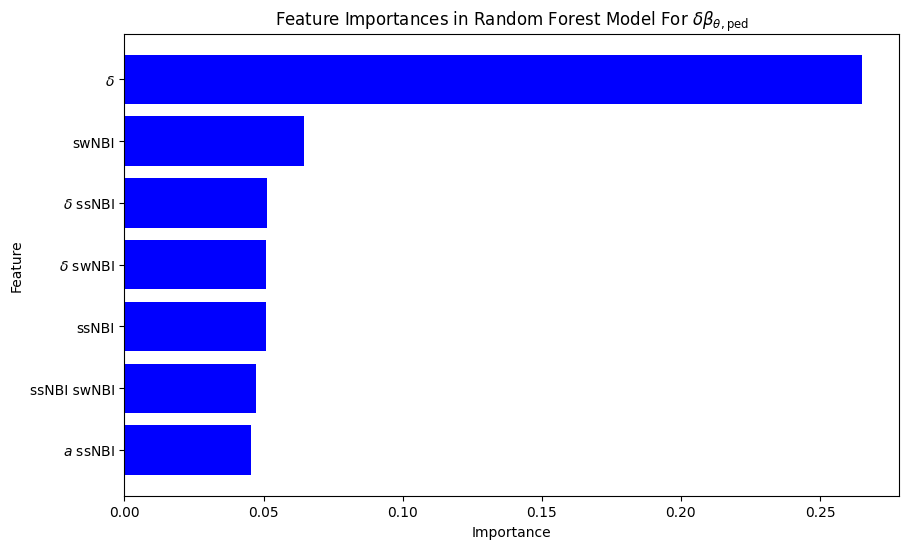

<Figure size 640x480 with 0 Axes>

In [ ]:

#### FEATURE IMPORTANCE

# Get the RandomForestRegressor from the pipeline
rf_model = model.named_steps['randomforestregressor']

# Feature importances
feature_importances = rf_model.feature_importances_

# Feature names
poly_feature_names = model.named_steps['polynomialfeatures'].get_feature_names_out()
feature_importance_dict = dict(zip(poly_feature_names, feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print sorted features with importances
print("Feature importances (sorted):")
for name, importance in sorted_features:
        print(f"Feature: {name}, Importance: {importance}")

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
feature_names_sorted = [item[0] for item in sorted_features]
importances_sorted = [item[1] for item in sorted_features]


#pedQuants = [r'$\langle | \nabla_N \alpha |^2 \rangle$',r'$\langle \nabla_N \alpha \cdot \nabla_N q \rangle$',r'$\langle | \nabla_N q |^2 \rangle$',r'$\langle \omega_{\kappa}^{\alpha} \rangle$',r'$\langle \omega_{\kappa}^{\alpha}-\omega_{\nabla B}^{\alpha} \rangle$',r'$\langle \omega_{\kappa}^{q} \rangle$',r'$\langle \mathrm{B} \rangle$', r'$\langle \hat{b} \cdot \nabla_N \theta \rangle$']
# pedQuants = [r'$H_{\psi_n}^{n_e}$', r'$H_{\psi_n}^{p_e}$', r'$H_{\psi_n}^{t_e}$', r'$H_{r}^{n_e}$', r'$H_{r}^{p_e}$', r'$H_{r}^{t_e}$', r'$W_{\psi_n}^{n_e}$', r'$W_{\psi_n}^{p_e}$', r'$W_{\psi_n}^{t_e}$', r'$W_{r}^{n_e}$', r'$W_{r}^{p_e}$', r'$W_{r}^{t_e}$', r'$\Delta_{ped}$',  r'$I_p$',r'$a$', r'$\delta$', r'$\kappa$', r'$NBI$', r'$\beta_N$', r'ELM%', r'greenwald', r'shot#', r'ssNBI', r'swNBI', r'times']
# no height
# pedQuants = [r'$W_{\psi_n}^{n_e}$', r'$W_{\psi_n}^{p_e}$', r'$W_{\psi_n}^{t_e}$', r'$W_{r}^{n_e}$', r'$W_{r}^{p_e}$', r'$W_{r}^{t_e}$', r'$\Delta_{ped}$',  r'$I_p$',r'$a$', r'$\delta$', r'$\kappa$', r'$NBI$', r'$\beta_N$', r'ELM%', r'greenwald', r'shot#', r'ssNBI', r'swNBI', r'times']
pedQuants = [r'$I_p$',r'$a$', r'$\delta$', r'$\kappa$', r'$NBI$',   r'ssNBI', r'swNBI']
# pedQuants = [r'$I_p$',r'$\delta$', r'$\kappa$']
newPedQuants = []
for i in np.arange(len(pedQuants)):
        if i not in removed_features:
                newPedQuants.append(pedQuants[i])
pedQuants = newPedQuants
# Mapping feature names to geo_quants
variable_mapping = {f'x{i}': name for i, name in enumerate(pedQuants)}
# Function to replace variables in composite names
def replace_feature_names(feature_name, mapping):
        pattern = re.compile(r'x\d+')
        return pattern.sub(lambda x: mapping[x.group()], feature_name)
# Replacing feature names with the actual variable names
feature_names_latex = [replace_feature_names(name, variable_mapping) for name in feature_names_sorted]

# Plot feature importances --- pick only top 7 variables!
top_filter = 7
plt.figure(figsize=(10, 6))
plt.barh(feature_names_latex[:top_filter], importances_sorted[:top_filter], color='b', align='center')
# ~ plt.barh(feature_names_sorted[:top_filter], importances_sorted[:top_filter], color='b', align='center')
# ~ plt.barh(feature_names_sorted[-top_filter:], importances_sorted[-top_filter:], color='b', align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(r'Feature Importances in Random Forest Model For $\delta \beta_{\theta,\mathrm{ped}}$')
plt.gca().invert_yaxis()
plt.show()
plt.savefig("plots/feature_importance_"+plotName+"_sampleEvery"+str(sampleEvery)+".png",bbox_inches='tight', pad_inches=0.1)




In [ ]:

#### PERMUTATION IMPORTANCE

# degree = 2

# # Create a pipeline with standardization, polynomial features, and Random Forest
# model = make_pipeline(StandardScaler(), PolynomialFeatures(degree), RandomForestRegressor())

# # Fit the model
# model.fit(X, y)

# # Calculate R^2
# r2 = model.score(X, y)
# print("R^2:", r2)

# Compute permutation importance
# result = permutation_importance(model, X, y, n_repeats=10, random_state=42, scoring='r2')
result = permutation_importance(model, X_sub, y_sub, n_repeats=10, random_state=42, scoring='r2')

# Get feature names
poly_feature_names = model.named_steps['polynomialfeatures'].get_feature_names_out()

# Exclude the constant term '1'
important_features = [name for name in poly_feature_names if name != '1']

# Get the permutation importance results
importances_mean = result.importances_mean
importances_std = result.importances_std

# Create a sorted list of features based on importance
sorted_idx = importances_mean.argsort()



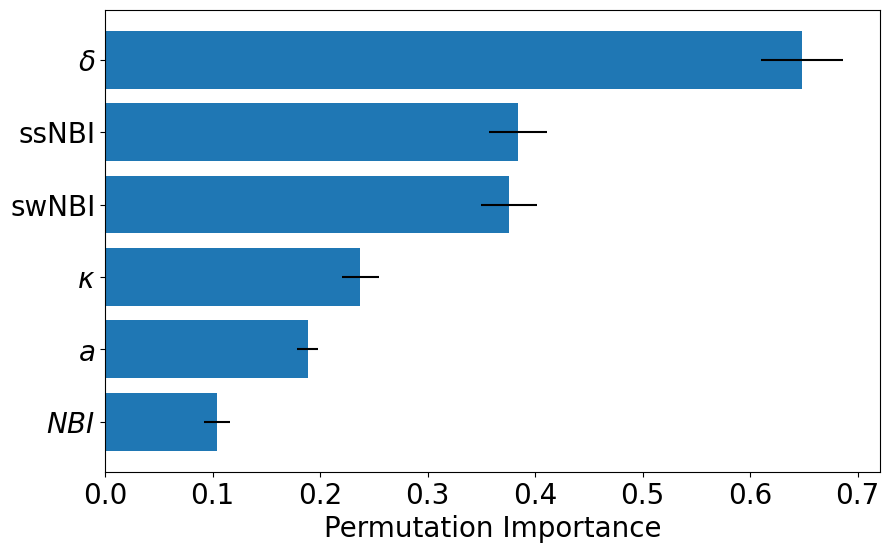

[0.10435801 0.18833882 0.23750438 0.37563724 0.38394547 0.64850035]


<Figure size 640x480 with 0 Axes>

In [ ]:

# Plot the permutation importance
plt.figure(figsize=(10, 6))
sorted_important_features = np.array(pedQuants)[sorted_idx]
sorted_importances_mean = importances_mean[sorted_idx]
bars=plt.barh(range(len(sorted_importances_mean)), sorted_importances_mean,  xerr=importances_std[sorted_idx], left = 0)
plt.yticks(range(len(importances_mean[sorted_idx])), sorted_important_features, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel(r"Permutation Importance", fontsize=20)
# plt.title(r"Permutation Importances in Random Forest Model for $\beta_{\mathrm{ped}}$")
plt.show()
plt.savefig("plots/permutation_importance_"+plotName+"_sampleEvery"+str(sampleEvery)+".png",bbox_inches='tight', pad_inches=0.1)
print(sorted_importances_mean)


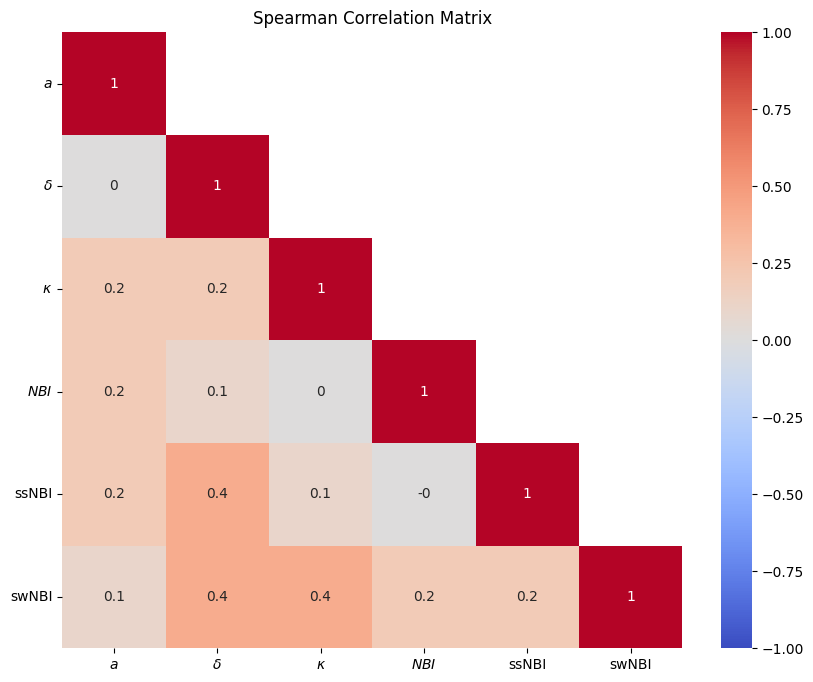

<Figure size 640x480 with 0 Axes>

In [ ]:

df = pd.DataFrame(X_sub)


# Compute the Spearman correlation matrix
spearman_corr = df.corr(method='spearman')

# Zero out the upper triangle of the correlation matrix, excluding the diagonal
mask = np.triu(np.ones_like(spearman_corr, dtype=bool), k=1)
spearman_corr.values[mask] = np.nan  # Using NaN to avoid displaying zero and to avoid confusion with actual zero correlations

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
ax=sns.heatmap(np.round(spearman_corr, 1), annot=True, cmap='coolwarm', vmin=-1, vmax=1,xticklabels=pedQuants, yticklabels=pedQuants)
ax.set_yticklabels(ax.get_yticklabels(),rotation=00)
plt.title('Spearman Correlation Matrix')
plt.show()
plt.savefig("plots/spearman_"+plotName+"_sampleEvery"+str(sampleEvery)+".png")



In [96]:
"""
Adapted from Jason Parisi machine_learning_local_prv.py
"""


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.pyplot import cm
# import netCDF4 as nc4
from scipy.interpolate import interp1d
import seaborn as sns
from copy import deepcopy
from scipy.stats import spearmanr
from scipy.integrate import simps
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from pathlib import Path
import time as timetime
import numpy as np
import re
import matplotlib.colors as mcolors
from pedestal import *


def remove_highly_correlated_features(X, threshold=0.8):
    """
    Remove features that are highly correlated with other features.
    
    Parameters:
    - X: numpy array of shape (n_samples, n_features)
    - threshold: correlation threshold for identifying highly correlated features
    
    Returns:
    - X_cleaned: numpy array with highly correlated features removed
    - removed_features: list of indices of features that were removed
    """
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)
    
    # Select upper triangle of correlation matrix
    upper = np.triu(corr_matrix, k=1)
    
    # Find features with correlation greater than the threshold
    to_drop = [i for i in range(upper.shape[0]) if any(upper[i, :] > threshold)]
    
    # Drop features
    X_cleaned = np.delete(X, to_drop, axis=1)
    
    return X_cleaned, to_drop


# load pedestal data from pkl file
a = Shot("allShots", "pkl")


######---- begin jfp edits

# Create a pipeline with standardization and a non-linear model
model = make_pipeline(StandardScaler(),  # Step 2: Generate polynomial features (optional, based on model needs)
	PolynomialFeatures(2), 
    RandomForestRegressor())  # Step 3: Fit a non-linear regression model

#extract pedestal parameters to fit
quantities_filtered = []
n_quantities = 25

# quantities_filtered.append(a.H_ped_psin_ne)
# quantities_filtered.append(a.H_ped_psin_pe)
# quantities_filtered.append(a.H_ped_psin_te)
# quantities_filtered.append(a.H_ped_radius_ne)
# quantities_filtered.append(a.H_ped_radius_pe)
# quantities_filtered.append(a.H_ped_radius_te)
quantities_filtered.append(a.Ip)
# quantities_filtered.append(a.W_ped_psin_ne)
# quantities_filtered.append(a.W_ped_psin_pe)
# quantities_filtered.append(a.W_ped_psin_te)
# quantities_filtered.append(a.W_ped_radius_ne)
# quantities_filtered.append(a.W_ped_radius_pe)
# quantities_filtered.append(a.W_ped_radius_te)
# quantities_filtered.append(a.W_ped)
# quantities_filtered.append(a.aratio)
# quantities_filtered.append(np.array(a.beamPower,dtype=float)) # cast to float
# quantities_filtered.append(a.betaN)
quantities_filtered.append(a.delta)
# quantities_filtered.append(a.elmPercent) # NaNs and Infs here
quantities_filtered.append(a.elong)
# quantities_filtered.append(a.greenwaldFraction) # NaNs and Infs here
# quantities_filtered.append(a.shotIndexed)
quantities_filtered.append(a.ssNBI)
quantities_filtered.append(a.swNBI)
# quantities_filtered.append(a.times)

X_temp = np.vstack(quantities_filtered).T
# y = a.W_ped
y = a.W_ped
# y = np.divide(a.Beta_ped,a.W_ped_psin_pe)
# e.g. there is a NaN in 42557 due to elmPercent -- see X_temp[42557]
allAfterFiltering = [11992, 14309, 43136, 66401, 17875, 19162, 20285, 20763, 43257, 45564, 47386, 47606, 49388, 51219, 54423, 54452, 60668, 60669, 62822, 64040, 64243, 14334, 60525, 60565, 60599, 64258, 64377, 70848, 20853, 42889, 44352, 52524, 63495, 70670, 70849, 71107, 42825, 43759, 49555, 53608, 56454, 61230, 62425, 64808, 64921, 64990, 65083, 66310, 68069, 68217, 68783, 71237, 12010, 19164, 42975, 43442, 49964, 51122, 60486, 62432, 65084, 65093, 65662, 66798, 42830, 42989, 43142, 43450, 44332, 46505, 47175, 48668, 56396, 59692, 60495, 62445, 63342, 65250, 67580, 42960, 43710, 44695, 44883, 45504, 46630, 46759, 51765, 55285, 55442, 60101, 63297, 21209, 55652, 62034, 65647, 68349, 14292, 9730, 11665, 11672, 23470, 25455, 25972, 43176, 51056, 54628, 59641, 60675, 62641, 64104, 64150, 64274, 64293, 64294, 64387, 64823, 70858, 70933, 9293, 21879, 44843, 47872, 50062, 52374, 53458, 54426, 70658, 70859, 70953, 71081, 71084, 71105, 71307, 21882, 44805, 45115, 46335, 47408, 52396, 53101, 53465, 60585, 61228, 62196, 64092, 65457, 66606, 67166, 67394, 68066, 68301, 70646, 70655, 70685, 70687, 71051, 71071, 9558, 17720, 19563, 42491, 43120, 44082, 44690, 46325, 46859, 47255, 47356, 47464, 50365, 59454, 60537, 60547, 62205, 63668, 66591, 66813, 67193, 70934, 71122, 9580, 10356, 14021, 21136, 21226, 22173, 22852, 42888, 44084, 44640, 44773, 46340, 46454, 46465, 46469, 46887, 47187, 47232, 47248, 47316, 47328, 49272, 49861, 50167, 50410, 50456, 51018, 51421, 51536, 51637, 51644, 52806, 53006, 53120, 54675, 55682, 59113, 59163, 59895, 61053, 61101, 61181, 61196, 61237, 61916, 61989, 62024, 64802, 65104, 66060, 66709, 67473, 68399, 70163, 70170, 70625, 70647, 70659, 70748, 9922, 10889, 11712, 42831, 42837, 43124, 43282, 43406, 43422, 44889, 46380, 46857, 46890, 47236, 47247, 47416, 47463, 48118, 48640, 49248, 49658, 49761, 50409, 51059, 51186, 51625, 51626, 51923, 51948, 51951, 52248, 52714, 52916, 52933, 53034, 54680, 54836, 56226, 60490, 60983, 61156, 61161, 61300, 62023, 62044, 62200, 62437, 63307, 63353, 63578, 65316, 65474, 66046, 67124, 68307, 68654, 68657, 70675, 70935, 70936, 70943, 9570, 10479, 19165, 19586, 22143, 22790, 42772, 43022, 43122, 43180, 43431, 43447, 44793, 44806, 44886, 44887, 45214, 45224, 46370, 46375, 46450, 46503, 46641, 46686, 46809, 46847, 46860, 47259, 47479, 48170, 48462, 48637, 49660, 49976, 50413, 50414, 50435, 51165, 51405, 51406, 51417, 51522, 51610, 51802, 51825, 52717, 53020, 53102, 53104, 53227, 53284, 54161, 54457, 55803, 56346, 59148, 59526, 59555, 59572, 60110, 60437, 61018, 61116, 61187, 61204, 61245, 61324, 61798, 62030, 63308, 63475, 63683, 63718, 65058, 65459, 65524, 66380, 66899, 67023, 67026, 67517, 67807, 68377, 68397, 68585, 68768, 68972, 70735, 71293, 71297, 9205, 42767, 42797, 42817, 42925, 43027, 43325, 43353, 43365, 43382, 43445, 43846, 44001, 44355, 44360, 44770, 46312, 46391, 46445, 46598, 46634, 47483, 47619, 48652, 49267, 49972, 50425, 51063, 51087, 51123, 51161, 51193, 51416, 51507, 51561, 51605, 51973, 52724, 52810, 53166, 54611, 54640, 54754, 56366, 59040, 59511, 61058, 61063, 61170, 61422, 61881, 61920, 62014, 63548, 63698, 63708, 64807, 64945, 65176, 66751, 67024, 67033, 67094, 68306, 68663, 70155, 70622, 70624, 71056, 71124, 9450, 10534, 13871, 19454, 19585, 26340, 42768, 42822, 43147, 43392, 43407, 43479, 43480, 44858, 44882, 44893, 46513, 47324, 47411, 47439, 48127, 48645, 49864, 49870, 49975, 51125, 51459, 51797, 51829, 51895, 53158, 54308, 54465, 54593, 54635, 54644, 55310, 56066, 56403, 56489, 58914, 59766, 60884, 61068, 61070, 61193, 61288, 61525, 61540, 61565, 61803, 62190, 65657, 66130, 66315, 66750, 66869, 17785, 20983, 42978, 43267, 43312, 46255, 46320, 46640, 47299, 48133, 48448, 48660, 49167, 49168, 49866, 50175, 51083, 52555, 52932, 52998, 53002, 54125, 54460, 54645, 54767, 55382, 59578, 59763, 59899, 61238, 61520, 61535, 61555, 61576, 61773, 61799, 61861, 63723, 63726, 63992, 65652, 68317, 71077, 71172, 9783, 10343, 10404, 10439, 13407, 18734, 46839, 47421, 49244, 53198, 54487, 54524, 58934, 59736, 61078, 61159, 61901, 64773, 65544, 67098, 68350, 68359, 68640, 13357, 13408, 19170, 19228, 45194, 46065, 46549, 47183, 48636, 48949, 51041, 52123, 53224, 54235, 58733, 59886, 61043, 61073, 61760, 61808, 63558, 66355, 67263, 68648, 45516, 46636, 46844, 47219, 48138, 48444, 61432, 61800, 62059, 64058, 64306, 68375, 68974, 17715, 17730, 17771, 48272, 51875, 54502, 66115, 46828, 52900, 54522, 56067, 56494, 61008, 61515, 68992, 68982, 10388, 69012, 11777, 22836, 44638, 49820, 50798, 60472, 64280, 70591, 71322, 19488, 22838, 43014, 46498, 47667, 49713, 51965, 53136, 53358, 55445, 59622, 60693, 62639, 63500, 70948, 71232, 10594, 43258, 45497, 45498, 46464, 49554, 52535, 54584, 64136, 64991, 64993, 68583, 69122, 71064, 71066, 10720, 21135, 21190, 21192, 42760, 44639, 46500, 51813, 52114, 52476, 52477, 53374, 53848, 59112, 62417, 64982, 65340, 67020, 68963, 70684, 70730, 71072, 168, 8852, 10892, 21129, 22796, 42523, 42956, 44335, 47334, 47407, 47475, 47691, 50426, 52357, 52899, 53477, 55771, 55786, 60505, 63347, 63350, 63496, 63601, 65164, 65194, 65587, 66510, 66611, 67019, 68575, 68580, 70628, 70638, 70854, 71111, 166, 10872, 10912, 11269, 15467, 21164, 21186, 21571, 22230, 42493, 42812, 46459, 46724, 47459, 47471, 50422, 51067, 51528, 51845, 51922, 51931, 51944, 52328, 53007, 54585, 55255, 55448, 59850, 62189, 62203, 62421, 63357, 65103, 66143, 66377, 66514, 66537, 66616, 66755, 67989, 70630, 71076, 71238, 9298, 13680, 17749, 18988, 21158, 42524, 42609, 43448, 44021, 44090, 44343, 44623, 44866, 45222, 46466, 46473, 46767, 47304, 48628, 48664, 48745, 49169, 49416, 50202, 50419, 51358, 51362, 51520, 51524, 51529, 51914, 51919, 52538, 53112, 53306, 54288, 54416, 54772, 54930, 55320, 55772, 56327, 58730, 58859, 59465, 59758, 61314, 61334, 63341, 63363, 63549, 63711, 63734, 64069, 64799, 64953, 65075, 66711, 66728, 66971, 66985, 67513, 70635, 70902, 71244, 8902, 9612, 9945, 10629, 13396, 17781, 20903, 20984, 21615, 21989, 42782, 42821, 42852, 43143, 43352, 43414, 43428, 43432, 44625, 45567, 45568, 46451, 46596, 47177, 47195, 47258, 48147, 48766, 49557, 49558, 50366, 50430, 51103, 51191, 51442, 52118, 52207, 52539, 54651, 54670, 54713, 54976, 56120, 59474, 59504, 59509, 59561, 59573, 59580, 61192, 61206, 61207, 61294, 61917, 62199, 63336, 63349, 63368, 63369, 63593, 63597, 63724, 63730, 65329, 65540, 65653, 66145, 66549, 66738, 68387, 70636, 70648, 70680, 70820, 71169, 9304, 11272, 14313, 17755, 19067, 21622, 21754, 21845, 22859, 42509, 42895, 42943, 42947, 42966, 43429, 43434, 43774, 44647, 44729, 44763, 44854, 46398, 46413, 46523, 46601, 46608, 46706, 46726, 47440, 48657, 49231, 49874, 50069, 50412, 51124, 51172, 51181, 52504, 52542, 53108, 53170, 53175, 53184, 54462, 54527, 54620, 54721, 55432, 55637, 55644, 56350, 56357, 58900, 58904, 60872, 61046, 61064, 61189, 61882, 61932, 62047, 62054, 63381, 63589, 63658, 65331, 65543, 66817, 70804, 8907, 9440, 9550, 9618, 10822, 13775, 17716, 18999, 42954, 44740, 44750, 45227, 46308, 46416, 46447, 46477, 46760, 46861, 47243, 47435, 47438, 47701, 48148, 48655, 49200, 49574, 51174, 51177, 51195, 51495, 52567, 53008, 53202, 53297, 54220, 54338, 54369, 54758, 54844, 54984, 56037, 56043, 56231, 56261, 56386, 58774, 59478, 59564, 59737, 59746, 59764, 59889, 60055, 60452, 60613, 61069, 61152, 61162, 61244, 61317, 61326, 61724, 61939, 61979, 62037, 62039, 64950, 65534, 65549, 65606, 66111, 66735, 67029, 67097, 70938, 71268, 203, 9143, 9600, 9878, 9886, 10486, 13608, 14204, 14240, 17732, 19539, 19568, 44810, 45202, 46599, 46702, 48137, 48293, 49882, 50171, 50401, 51052, 52607, 53190, 53191, 54363, 54383, 54538, 54556, 54630, 54965, 54980, 58936, 59712, 59769, 59821, 59822, 60081, 61132, 61250, 61435, 61490, 61495, 61563, 61785, 61805, 61900, 61936, 62049, 63470, 65627, 65668, 66131, 67034, 67118, 68396, 68413, 69040, 71061, 9141, 9578, 14048, 26488, 44390, 44798, 45174, 48134, 48740, 49196, 49560, 50402, 50440, 51133, 51888, 52556, 52807, 53098, 53210, 54376, 54526, 54548, 54600, 54653, 54858, 54859, 55133, 55291, 55309, 56229, 58758, 58923, 59747, 61107, 61377, 61554, 61774, 61809, 62056, 64768, 65530, 66365, 67071, 67242, 67383, 68379, 68395, 71060, 42807, 43849, 44697, 45177, 46805, 48126, 52419, 54260, 54472, 54505, 56032, 56376, 59727, 60417, 61027, 61442, 65663, 66137, 66371, 66843, 67188, 68290, 68650, 9477, 9729, 10409, 10433, 10614, 13752, 13760, 19127, 21179, 53214, 54240, 55774, 61560, 61858, 62179, 65191, 65612, 67064, 68438, 9725, 13737, 54528, 54728, 58891, 59557, 66366, 19117, 49124, 49926, 54128, 54615, 65504, 66828, 18989, 50101, 54324, 61763, 62182, 21780, 65519, 68824, 48435, 61428, 67063, 69023, 13820, 69007, 19160, 59191, 62625, 14275, 44410, 47762, 54021, 60556, 66301, 70673, 9108, 9123, 14110, 14333, 18743, 25528, 44923, 45134, 53843, 62357, 64281, 66045, 67469, 71312, 21306, 25543, 42505, 44691, 48253, 51047, 51455, 53493, 59605, 62415, 63511, 64046, 64919, 65106, 66445, 66448, 70645, 70657, 70676, 70722, 70851, 10424, 13392, 15465, 21211, 44098, 44719, 51920, 53383, 53645, 55668, 55783, 59880, 60040, 62098, 63517, 64806, 64923, 64978, 66504, 66531, 67168, 68581, 69115, 70440, 71087, 71305, 10465, 11270, 11273, 14164, 23009, 42475, 42507, 42508, 44068, 44088, 44091, 46446, 47226, 47462, 47472, 47770, 48625, 51121, 51535, 54838, 54950, 55802, 60517, 62440, 64151, 64960, 64981, 65102, 65332, 66507, 66512, 68750, 70652, 70654, 70889, 71057, 71239, 9128, 10901, 13864, 21676, 22213, 42481, 42492, 42526, 43711, 44121, 44765, 44891, 46840, 46855, 47692, 47767, 48173, 48743, 48764, 49391, 50428, 50443, 51019, 51629, 52413, 55441, 59456, 59548, 59571, 60045, 61302, 62201, 62418, 63372, 63733, 64783, 65089, 67515, 68304, 70442, 70634, 70650, 70959, 71284, 71299, 71306, 169, 9122, 9860, 10390, 10725, 11271, 13687, 21576, 42479, 42480, 42495, 42844, 43367, 44113, 44376, 44784, 46316, 46390, 46418, 47178, 47478, 48739, 48752, 49992, 50125, 51409, 51641, 51819, 51927, 51941, 52720, 52824, 53167, 53853, 54257, 54289, 54633, 55275, 55434, 56369, 58899, 59137, 59156, 59554, 59565, 60036, 60075, 61553, 62029, 62193, 62428, 63295, 63335, 63352, 63365, 63653, 63736, 64815, 65087, 65660, 67512, 67822, 70643, 71063, 9194, 9479, 9525, 9564, 10362, 10384, 10389, 20787, 42494, 42795, 43322, 43709, 44315, 46389, 46885, 47341, 47769, 48119, 48452, 48674, 48737, 51084, 51360, 51503, 51806, 52329, 52434, 52901, 54162, 54477, 54751, 54931, 54947, 54953, 56040, 56470, 59563, 59890, 61290, 61329, 61500, 61726, 62050, 63306, 63982, 64789, 65330, 65622, 66535, 68311, 68414, 71086, 71089, 71181, 71184, 9126, 9196, 9211, 9445, 9552, 9575, 9858, 9863, 10471, 26512, 42965, 44312, 44350, 44648, 44779, 44790, 44865, 46467, 46792, 47344, 47390, 48176, 48650, 48666, 49235, 50420, 51162, 51180, 52212, 54165, 54768, 54975, 54994, 56392, 58757, 59124, 59893, 59900, 60510, 61573, 61935, 63666, 64757, 64788, 64930, 65327, 65607, 66707, 66723, 68364, 68429, 68718, 70945, 70958, 71139, 9184, 9221, 10420, 11655, 13872, 13992, 14055, 14137, 18914, 19299, 42942, 43402, 43593, 44327, 44856, 46252, 46425, 46543, 46829, 47185, 47189, 47203, 47391, 47419, 47700, 48460, 48654, 49661, 49934, 51088, 51091, 51166, 51846, 52606, 53300, 54684, 55633, 58895, 59494, 60442, 61235, 61242, 61337, 61429, 61543, 61725, 61921, 61931, 62028, 65673, 66313, 66538, 66733, 66883, 67038, 67113, 70640, 70766, 71262, 9598, 9913, 10438, 10504, 10559, 14255, 18964, 20826, 43288, 46725, 46764, 47332, 48128, 48286, 49145, 49216, 49296, 49691, 50074, 52210, 52431, 54634, 54992, 55316, 56038, 56052, 56235, 56241, 56254, 56387, 58937, 59568, 60984, 61286, 61444, 61790, 61890, 65167, 65470, 67088, 68105, 68409, 68425, 10491, 11279, 13767, 13790, 13814, 14049, 19120, 21751, 43357, 43391, 46650, 47490, 48967, 48978, 48979, 49695, 49768, 50138, 51203, 52722, 54388, 54601, 54671, 54849, 54864, 55321, 55419, 55747, 55748, 56351, 56356, 56373, 60887, 61171, 61246, 61287, 61378, 61505, 63302, 66969, 68763, 68894, 70746, 70750, 13779, 17763, 44378, 45183, 48971, 49677, 51151, 52417, 52558, 52994, 54343, 56382, 58782, 58893, 59896, 61003, 61019, 61126, 61277, 61562, 61580, 61813, 61906, 61911, 62117, 64359, 65038, 66343, 67093, 68358, 68386, 68899, 70825, 71078, 13791, 13795, 18977, 46311, 46460, 46557, 49577, 49981, 51189, 52418, 52546, 54359, 61253, 63445, 65175, 66110, 45159, 46603, 51773, 54104, 54222, 54769, 60046, 61240, 61521, 65489, 66311, 68884, 68910, 13989, 17708, 18944, 46403, 46774, 61127, 61269, 62132, 13996, 47199, 53237, 54349, 55079, 61522, 61537, 19390, 48944, 49048, 56003, 66892, 68424, 71174, 71179, 64659, 52552, 54501, 70032, 52490, 68261, 49718, 11267, 15327, 17874, 19291, 54827, 62411, 64049, 68702, 68962, 8850, 10373, 13593, 22927, 47388, 52202, 53727, 54829, 60584, 64994, 65346, 70693, 9820, 10464, 18740, 18741, 21055, 21302, 22242, 22800, 43584, 43883, 45565, 48765, 53014, 53316, 53328, 60533, 62412, 65099, 65336, 67507, 70651, 70678, 71315, 12008, 15332, 21308, 49290, 50813, 51647, 53313, 53388, 53851, 56455, 60508, 60532, 60534, 60542, 61841, 63609, 63648, 65024, 65105, 65297, 70653, 70683, 13387, 13718, 13933, 17877, 20815, 20924, 21154, 21163, 25589, 42522, 44132, 45499, 48153, 50431, 50444, 52809, 53030, 54586, 55671, 59546, 60512, 61229, 63423, 64961, 64976, 64980, 64989, 65300, 65586, 66503, 67348, 70667, 70681, 71298, 186, 10379, 10383, 18919, 23014, 23743, 46336, 47179, 49023, 51818, 52449, 52822, 53036, 53844, 53852, 55664, 59520, 59575, 60513, 61231, 63378, 63385, 64813, 64977, 66047, 66542, 68419, 68713, 70160, 71164, 9718, 10363, 10401, 10781, 10902, 13670, 14412, 23580, 23815, 43315, 44778, 46433, 47458, 48171, 48667, 48669, 49024, 50168, 51071, 51357, 51538, 51562, 51627, 52566, 53109, 54952, 55370, 55443, 55991, 60070, 65068, 65074, 65645, 66556, 66582, 66758, 68298, 68405, 71115, 208, 8894, 9139, 9213, 9467, 9728, 10442, 10879, 13686, 14206, 20965, 23824, 42970, 43589, 43856, 46475, 46631, 46799, 47186, 51136, 51361, 51425, 51527, 51622, 52206, 53026, 54160, 59598, 59600, 60039, 60883, 61485, 63323, 63344, 63367, 65165, 66743, 66757, 66960, 67514, 67606, 67825, 67913, 68373, 70027, 70649, 70765, 70937, 9173, 9188, 9540, 9885, 10434, 10628, 10871, 11673, 14043, 14147, 18954, 20990, 43202, 43262, 43712, 44725, 44813, 46383, 47234, 47495, 48653, 48774, 49172, 51035, 51099, 51621, 52543, 52812, 53078, 54255, 55423, 58729, 58756, 59123, 59589, 59767, 60090, 61997, 62052, 62209, 63603, 64678, 64794, 66708, 66714, 66800, 9609, 9848, 9928, 10496, 10730, 14033, 14377, 14432, 18909, 19045, 19298, 21652, 21661, 21690, 43032, 43204, 43592, 43888, 44354, 44855, 46378, 46400, 46410, 46579, 50137, 51073, 51145, 51146, 51821, 51911, 51913, 52905, 54101, 54996, 56462, 59484, 59576, 59750, 61299, 61493, 61743, 61995, 64671, 66823, 66968, 67027, 68417, 70037, 70738, 70917, 71059, 71187, 8910, 9176, 9410, 9792, 10519, 10521, 13807, 14425, 17748, 19173, 21778, 42833, 43764, 45185, 46711, 46831, 48415, 49203, 49264, 49905, 50179, 50375, 51139, 53010, 54512, 54529, 54730, 54991, 55045, 56030, 56237, 56358, 56401, 58930, 60083, 61044, 61280, 61407, 61564, 61787, 61876, 63430, 65311, 65469, 66972, 67831, 68351, 70761, 70923, 70924, 71134, 9573, 10410, 10416, 10422, 10501, 13792, 14035, 17335, 21809, 21975, 43851, 44775, 44878, 46392, 46524, 47223, 48304, 49405, 49663, 49665, 54164, 54665, 54681, 54763, 54773, 56036, 58916, 58917, 59471, 60895, 61135, 62019, 63337, 64780, 66080, 66816, 66970, 67115, 67179, 68221, 68402, 68416, 68659, 68660, 68970, 70028, 70745, 70893, 71058, 9199, 9868, 10348, 10431, 14044, 14066, 25168, 43441, 44310, 44369, 46397, 46668, 46714, 47422, 47699, 48724, 52496, 52801, 53100, 53222, 54469, 54648, 55301, 58919, 61335, 61886, 61999, 68664, 68822, 68869, 71118, 9818, 10750, 11275, 13783, 13813, 13997, 14385, 14409, 19415, 45511, 45571, 46401, 47424, 48459, 48975, 49198, 49570, 51129, 52909, 54298, 54545, 55074, 56031, 58906, 61004, 61789, 64341, 66327, 66827, 66896, 68360, 9795, 13738, 13821, 14155, 20240, 43425, 44387, 46681, 49151, 50075, 51201, 54717, 54783, 55643, 59142, 59147, 60084, 60885, 64699, 66850, 68879, 19507, 46508, 46528, 47735, 48416, 48937, 50129, 56216, 65643, 65667, 68844, 70874, 11666, 14047, 14174, 19448, 48418, 49259, 51781, 54500, 56007, 61241, 61260, 68835, 13759, 13785, 13793, 48432, 48456, 51138, 58872, 61111, 64345, 14124, 43149, 46580, 47423, 58740, 58929, 13825, 49138, 64651, 68834, 46538, 48131, 14636, 48421, 50113, 53092, 68864, 22006, 47212, 70045, 21689, 49902, 9713, 9714, 13715, 22988, 50022, 11780, 14276, 21050, 25995, 42521, 47612, 47785, 50810, 60528, 64248, 64376, 68574, 68748, 71314, 21307, 44412, 44615, 46055, 46882, 49181, 51849, 51863, 51864, 53461, 54286, 59574, 60531, 60540, 63392, 66305, 66502, 70656, 8724, 18744, 42506, 47765, 48772, 53132, 53726, 54121, 58726, 59545, 60520, 60529, 63610, 64975, 66509, 70702, 9577, 10721, 10907, 26561, 44124, 44133, 44692, 48768, 50427, 52537, 52825, 59547, 60524, 63965, 64379, 66490, 66609, 70644, 70856, 71321, 10393, 10435, 10900, 17760, 21178, 23750, 44101, 46629, 53015, 53029, 53123, 55782, 56326, 59126, 59825, 62208, 64404, 64740, 64741, 65096, 65098, 65100, 66466, 66551, 67579, 70664, 70956, 177, 185, 195, 10398, 10887, 13903, 14072, 20887, 21730, 46854, 47447, 47449, 49161, 51935, 52791, 52820, 53612, 55369, 55607, 55776, 56330, 59590, 59604, 62439, 63343, 63731, 65251, 65343, 65458, 66455, 66492, 66536, 66615, 68715, 70949, 71240, 71256, 202, 213, 9435, 9916, 10350, 10878, 19072, 20963, 22150, 42819, 42835, 43017, 43420, 43834, 43991, 44019, 44123, 44899, 46280, 46470, 47474, 47492, 49188, 49393, 50390, 51609, 51617, 51915, 52716, 53003, 53305, 53308, 53312, 54944, 59523, 59860, 62185, 63706, 66458, 66888, 66893, 68721, 68820, 70159, 70443, 70445, 8903, 9133, 9938, 10345, 13688, 13693, 14081, 14436, 42496, 43125, 43199, 44053, 44780, 46381, 46707, 47231, 47467, 49112, 49260, 51064, 51613, 52708, 53028, 53107, 53117, 53600, 54098, 54458, 54734, 59487, 61451, 62442, 63506, 63703, 65630, 66753, 66806, 66818, 66886, 67603, 68098, 68398, 70619, 70869, 70929, 10346, 10418, 10425, 10745, 14285, 14399, 14414, 19560, 20785, 20947, 21633, 22008, 22889, 44650, 44731, 44868, 45503, 46253, 46330, 46440, 47222, 47493, 47771, 48263, 48409, 48676, 48760, 49194, 49197, 51842, 51970, 53095, 53235, 55118, 59468, 59885, 60050, 61295, 61980, 62207, 64751, 64803, 65088, 65306, 65464, 66050, 66456, 66859, 67990, 68392, 68658, 70149, 70165, 70639, 70744, 71277, 9151, 9430, 9460, 9607, 9936, 10740, 13445, 14086, 14398, 19428, 19557, 42770, 43047, 44374, 46333, 46769, 48651, 49398, 49668, 49707, 49868, 50141, 51023, 53004, 53234, 54294, 54430, 54595, 54606, 54736, 54940, 55123, 56033, 58754, 59582, 59894, 60910, 61891, 63315, 64787, 64935, 67919, 68420, 70741, 70941, 9207, 10417, 13442, 13788, 13811, 14314, 14382, 14654, 17764, 44291, 44815, 46522, 48656, 48973, 49298, 49564, 50086, 50378, 51140, 51205, 51889, 51907, 52497, 54729, 56377, 59153, 59470, 60899, 61275, 63435, 63728, 64397, 64932, 65592, 65618, 67607, 68018, 9137, 9154, 10553, 13390, 14119, 14184, 14430, 17380, 42902, 43314, 44010, 44884, 49602, 50115, 52433, 52816, 54608, 54970, 55322, 59168, 61137, 61259, 61305, 61306, 61539, 63713, 64941, 66729, 66740, 66838, 66978, 67258, 68362, 68372, 68378, 68665, 70432, 70740, 9218, 9482, 9944, 10569, 14029, 14056, 14376, 14391, 14427, 18952, 18959, 19255, 21791, 22005, 42810, 42928, 44367, 44871, 46386, 46647, 46824, 47436, 48150, 49252, 49582, 51158, 52914, 55403, 55408, 55437, 56272, 56480, 59135, 59865, 60906, 61183, 64940, 65312, 65529, 66745, 66980, 67398, 13852, 14397, 14423, 19056, 44292, 44751, 44766, 46399, 46609, 47235, 47696, 49922, 52814, 53854, 58879, 58910, 60106, 61131, 61409, 65597, 67178, 14149, 17743, 46480, 48952, 48964, 49983, 50114, 53187, 54314, 54622, 54637, 55128, 56054, 58767, 58775, 58778, 60111, 60392, 64315, 70925, 14372, 21058, 43148, 43154, 43388, 47315, 47427, 56056, 56264, 60889, 61393, 64175, 65063, 66058, 68020, 13755, 46421, 48433, 50085, 52336, 52562, 53207, 61129, 64758, 68870, 19193, 19200, 48301, 48423, 49980, 54108, 61447, 61887, 68281, 45216, 54499, 54646, 58905, 60086, 66331, 68600, 68994, 49147, 50089, 13377, 54185, 17710, 66321, 62141, 11662, 22991, 43986, 53490, 67786, 21051, 22585, 22814, 43703, 46366, 46627, 47722, 49289, 49758, 55781, 62756, 64255, 68961, 71320, 161, 8986, 11642, 21198, 21983, 42890, 44048, 52382, 52588, 53027, 53314, 54771, 55679, 59058, 59628, 70688, 70699, 10338, 21225, 22839, 46052, 47174, 50451, 51120, 52384, 53127, 53473, 55669, 55672, 61741, 62414, 64020, 64973, 65299, 70668, 70697, 8857, 9648, 13336, 14112, 21138, 22952, 25076, 44644, 44721, 44804, 46365, 48869, 51356, 51531, 53152, 53379, 53548, 55678, 59519, 60530, 62438, 63420, 64449, 64984, 64986, 65456, 66447, 66508, 67167, 70661, 70731, 71080, 71109, 8887, 8988, 10344, 10868, 10891, 10913, 10914, 11781, 13902, 21126, 22001, 26426, 42607, 43990, 44081, 45502, 46474, 47455, 48627, 48956, 49186, 49659, 51766, 54839, 55673, 60488, 60496, 60519, 61071, 61974, 63513, 64920, 64964, 64971, 64979, 65081, 65097, 66497, 66517, 66519, 66522, 66608, 66697, 66754, 66756, 70863, 70942, 71069, 165, 8865, 8904, 9522, 10421, 21162, 21814, 22176, 22325, 23759, 43140, 47481, 49559, 51939, 53282, 55674, 56200, 59169, 60105, 60483, 60499, 61102, 61924, 62198, 62443, 65027, 66496, 66613, 70677, 70888, 228, 9136, 9405, 9543, 10361, 10405, 10436, 10467, 13418, 14057, 17295, 19445, 21742, 22357, 43260, 43831, 44134, 44353, 44898, 46344, 46858, 47477, 49156, 50449, 51630, 51633, 52723, 53018, 53032, 53093, 53163, 59525, 59553, 59570, 60085, 60491, 61319, 63654, 64969, 65079, 66593, 66594, 68382, 68407, 71267, 9202, 9217, 9417, 9472, 9534, 10372, 10811, 10890, 18726, 22851, 26310, 43317, 43354, 44853, 44900, 46432, 47491, 48749, 50816, 51817, 51827, 52817, 52818, 52823, 53168, 55391, 59035, 59160, 59516, 59583, 60869, 61285, 61981, 61994, 63604, 64108, 64786, 64801, 65531, 66378, 67599, 67915, 68411, 68717, 69066, 71247, 71295, 9080, 9583, 9852, 10407, 10727, 10877, 11650, 13780, 18729, 18969, 42813, 42919, 43144, 43316, 46635, 47453, 48661, 51194, 51414, 51870, 52779, 53012, 53780, 54358, 55260, 59490, 59513, 61197, 61332, 61450, 62051, 63473, 63486, 63595, 63719, 64925, 64955, 66457, 66975, 68011, 68655, 70180, 204, 9416, 9528, 9595, 10642, 13420, 13616, 13651, 13786, 14631, 19265, 19554, 19583, 20837, 20917, 43355, 44330, 44383, 44696, 44812, 46590, 47320, 47412, 48673, 50411, 51190, 51917, 52211, 52803, 52920, 53113, 54123, 54461, 54589, 54591, 54852, 54860, 56228, 59515, 59693, 60095, 61568, 63659, 65535, 66309, 66819, 66959, 68308, 68401, 70161, 70441, 9201, 9745, 9851, 9921, 10412, 10429, 10664, 14159, 14287, 14374, 19452, 20912, 21686, 21963, 42842, 42986, 43218, 43318, 43418, 43482, 45199, 46251, 46441, 46504, 46511, 46591, 46600, 47251, 50383, 50398, 51053, 51068, 51150, 53162, 53171, 53238, 54724, 55766, 56041, 58918, 59475, 59770, 60107, 60357, 60881, 60998, 61049, 61417, 61425, 61541, 61780, 61781, 61998, 62000, 64138, 65633, 66328, 66370, 66719, 66742, 67833, 70184, 70818, 70878, 71252, 9183, 9572, 9930, 13618, 13764, 14050, 14402, 17503, 19137, 22035, 42828, 43300, 44007, 44308, 44357, 46254, 46431, 46652, 48287, 48303, 49671, 49673, 50207, 51027, 51039, 51169, 53156, 53199, 54530, 54660, 54979, 56049, 58732, 59125, 59164, 60900, 60901, 61038, 61136, 61852, 62064, 62114, 63332, 63485, 63490, 64342, 64800, 65536, 65659, 66126, 66898, 67031, 67123, 67921, 68434, 68758, 10564, 11674, 13411, 13640, 14076, 17298, 17668, 19523, 21848, 44814, 46385, 46393, 46434, 46449, 47348, 48289, 48300, 48453, 49424, 49440, 49879, 51393, 54467, 54655, 54674, 54679, 55298, 55427, 56236, 56389, 59130, 59140, 59145, 59480, 59739, 61249, 61851, 66845, 66848, 66880, 68371, 68385, 70038, 71254, 9883, 13748, 13751, 13753, 13800, 13832, 14046, 14352, 14395, 14416, 19250, 19508, 26508, 43359, 43484, 44651, 45188, 46404, 46407, 46506, 46525, 47340, 48261, 48292, 48451, 48633, 49573, 49777, 51142, 53226, 53296, 54558, 54650, 54761, 58911, 60886, 61045, 61145, 61267, 62002, 62015, 64275, 65602, 66138, 68357, 70026, 10556, 13774, 13826, 14357, 14387, 19430, 43219, 46347, 46606, 46699, 47194, 48449, 49038, 49136, 49776, 49890, 50136, 50226, 51801, 52673, 53197, 54625, 56243, 56244, 58766, 59558, 61234, 61783, 62001, 63663, 64176, 65494, 66320, 67309, 67369, 70770, 13830, 46814, 47468, 49146, 50203, 52495, 54303, 54597, 54669, 55125, 58763, 58924, 61750, 65677, 68369, 68874, 14139, 19057, 19223, 19533, 19538, 42777, 47193, 48420, 49420, 49872, 50393, 54723, 59720, 59745, 60902, 61336, 66055, 67177, 67423, 68236, 70775, 71176, 13777, 45513, 46298, 46444, 52344, 53089, 58749, 63583, 71189, 14011, 14380, 46697, 48963, 49709, 56005, 58909, 65185, 46588, 47426, 53204, 55296, 58765, 68286, 49428, 61770, 64284, 67431, 68889, 19210, 20904, 56268, 64473, 46300, 48424, 49591, 64401, 68849, 54506, 46305, 70566, 67433, 11643, 14230, 20507, 21301, 22778, 44844, 49389, 50363, 50827, 51119, 52400, 54094, 54831, 54832, 59543, 59638, 60349, 60559, 62627, 63544, 64262, 68778, 9389, 9716, 11493, 12009, 19292, 20885, 21304, 22260, 23594, 25481, 25482, 43599, 53334, 59057, 64178, 69128, 162, 9518, 11268, 12005, 21725, 22443, 24973, 25609, 44073, 46883, 50429, 51646, 52203, 52589, 55792, 59029, 59607, 60501, 61738, 63975, 64983, 64992, 65344, 65585, 66446, 70663, 70695, 9165, 9715, 10865, 10906, 12006, 13335, 19487, 20735, 22343, 44071, 47450, 49390, 49759, 49760, 51639, 53019, 53373, 55785, 60492, 60536, 62416, 64737, 64922, 65025, 65334, 66521, 70674, 70700, 9521, 10340, 10882, 10893, 13665, 14052, 19038, 42604, 43708, 44069, 44083, 48932, 51624, 51940, 55780, 55801, 60480, 60482, 62420, 62422, 62427, 63388, 63656, 65028, 66516, 66520, 66698, 67474, 68348, 70669, 8862, 8879, 9190, 9843, 10915, 10917, 21168, 21586, 22179, 24146, 42511, 42608, 42940, 43765, 44620, 49392, 50453, 51532, 51618, 51924, 52819, 53021, 53022, 53105, 53849, 54588, 55737, 59464, 60115, 60609, 62434, 63732, 64072, 64963, 66713, 66961, 184, 8884, 9186, 9526, 10341, 10898, 13799, 23552, 23746, 42478, 42603, 44079, 44087, 44103, 44116, 45139, 46607, 46867, 47389, 47725, 48174, 48776, 49164, 50821, 51634, 52706, 52719, 53118, 54842, 54936, 55649, 59455, 59514, 61291, 61988, 63296, 63425, 63702, 63981, 64743, 64809, 64967, 64970, 65095, 65655, 66534, 66731, 68010, 70951, 71183, 71301, 71308, 217, 221, 8882, 8900, 9246, 9300, 9523, 9544, 9556, 10357, 10550, 10734, 11690, 11713, 19240, 19558, 20923, 20977, 21977, 42510, 42857, 43323, 43713, 44030, 44361, 44693, 44894, 44901, 46060, 46479, 47336, 49268, 49566, 49606, 49863, 51422, 51435, 51619, 51824, 51830, 51838, 51969, 53096, 53097, 54714, 54941, 54951, 55175, 55323, 55662, 56025, 59154, 59486, 59521, 59581, 59594, 59823, 60113, 60982, 61284, 61318, 63716, 66146, 66306, 66555, 66749, 67510, 70946, 215, 227, 8896, 9163, 9415, 9723, 13405, 13781, 13815, 14031, 18942, 18957, 20948, 20989, 21316, 22044, 42977, 43051, 43594, 44057, 44115, 44290, 44336, 44341, 44885, 46780, 46849, 47297, 47300, 47355, 47415, 48461, 50219, 50229, 50407, 50423, 51413, 51514, 51614, 51809, 51840, 51841, 52715, 52907, 53119, 54099, 54636, 54685, 54954, 55315, 55402, 55435, 56046, 56402, 59171, 59517, 59518, 60986, 60993, 61982, 61996, 63322, 63386, 63387, 63426, 64793, 66375, 66376, 66459, 66739, 66799, 67808, 67810, 67901, 68294, 70156, 70732, 70864, 71088, 71258, 219, 224, 9890, 10391, 10397, 10482, 10602, 10677, 13345, 13725, 13802, 13883, 17353, 19492, 19496, 23722, 42771, 42805, 42818, 42838, 42850, 43146, 43767, 44059, 44811, 46373, 46458, 46481, 46482, 47188, 47215, 47727, 48260, 48297, 48442, 48455, 49429, 50135, 51149, 51153, 51811, 52802, 53160, 54361, 54550, 54983, 55312, 55417, 55447, 56039, 56050, 58908, 59165, 59492, 60102, 60907, 60988, 61186, 61331, 62035, 63333, 63382, 63671, 64804, 65196, 65550, 65555, 65670, 66724, 66811, 66877, 67602, 70561, 70620, 70805, 71120, 71173, 71253, 71257, 9140, 9423, 9563, 9651, 10606, 10675, 10794, 17636, 17783, 19446, 20839, 20844, 22997, 26446, 42783, 42786, 42903, 42939, 42955, 43276, 43295, 43430, 44063, 44802, 46530, 47451, 47729, 48936, 49027, 49030, 49257, 49269, 50001, 50828, 51034, 51043, 51079, 52711, 52799, 52805, 52811, 53114, 53219, 54542, 54629, 54741, 55440, 55638, 55645, 56060, 56248, 56371, 56395, 58926, 59167, 59499, 59508, 61194, 61268, 61333, 61925, 63355, 64620, 65497, 66730, 66807, 66889, 67078, 67902, 68016, 68435, 70632, 70926, 9574, 9803, 10627, 10679, 10689, 10699, 17758, 19247, 42814, 43308, 43413, 44031, 44302, 44734, 44761, 44867, 44888, 45192, 45510, 46653, 46825, 46856, 47190, 47325, 48135, 49192, 49567, 49967, 50109, 50174, 50187, 51060, 51178, 51427, 51565, 51908, 52707, 53161, 53188, 54598, 54740, 54865, 54962, 56238, 56239, 56487, 58889, 60362, 60447, 60879, 61439, 62055, 63377, 63680, 63688, 63699, 64748, 65189, 66119, 66732, 66737, 66822, 66854, 66858, 66894, 66992, 67028, 67083, 68720, 70433, 9158, 9429, 9457, 9571, 9593, 9613, 9888, 9914, 9934, 10541, 10546, 13749, 14405, 17698, 19499, 19501, 22866, 42827, 42985, 43049, 43151, 43285, 43383, 43779, 44321, 44324, 44745, 46290, 46561, 46585, 46761, 47359, 48670, 49876, 49928, 50128, 50822, 51141, 51163, 51903, 52725, 53001, 54610, 55311, 55319, 55628, 56339, 59740, 59744, 61256, 63303, 63686, 64189, 64791, 65041, 65505, 65527, 65658, 66746, 66808, 68107, 68971, 70922, 9446, 10476, 10634, 13633, 13765, 13766, 13987, 14027, 14191, 19551, 42920, 43150, 44755, 44760, 45200, 45514, 46315, 46435, 47214, 48295, 49309, 49310, 49561, 50133, 51126, 51127, 51798, 52332, 52486, 53229, 54304, 54999, 55277, 56336, 56341, 56362, 59753, 59878, 60441, 60894, 61032, 61117, 61176, 61279, 61297, 61496, 61792, 64432, 65039, 65554, 65638, 65679, 66149, 66358, 67043, 67834, 68423, 70444, 70743, 70781, 70815, 71054, 71175, 9596, 9765, 9785, 10571, 14061, 17769, 19502, 42980, 43277, 43398, 43426, 44872, 45219, 46765, 46771, 47469, 48271, 48278, 48302, 49163, 49432, 50000, 50144, 54221, 54252, 54547, 56034, 58902, 59897, 60395, 61080, 61201, 61258, 61266, 61794, 61795, 62060, 63436, 63469, 65596, 66154, 66318, 67109, 68244, 68370, 68374, 68645, 70431, 70780, 9148, 13729, 17790, 18984, 19460, 19506, 19513, 21729, 42973, 45209, 46733, 47704, 49149, 49204, 49250, 50081, 50121, 52493, 53301, 54482, 55619, 56478, 60112, 60404, 61400, 61728, 63434, 63565, 65548, 66063, 68017, 68366, 70883, 71155, 10732, 14242, 17718, 44391, 46329, 46568, 47249, 48734, 49039, 50105, 50382, 50388, 54105, 54471, 54765, 54778, 55305, 56250, 56276, 58784, 60418, 61559, 65177, 66326, 68363, 68651, 71055, 71136, 10446, 21999, 44873, 46260, 46535, 46845, 47326, 48419, 48940, 49562, 50130, 51366, 52345, 54293, 54301, 54627, 58898, 59882, 61376, 66335, 66840, 68241, 71154, 43419, 45149, 47773, 50384, 54313, 54497, 54596, 61239, 63573, 65264, 67243, 9658, 19225, 43037, 45187, 47228, 49590, 54215, 54494, 56219, 59722, 65509, 67232, 67362, 68431, 53193, 58783, 61392, 61513, 65486, 68854, 21575, 45170, 46721, 49139, 51883, 64456, 19213, 51977, 54339, 55138, 68250, 14686, 49986, 59721, 61768, 67058, 46572, 65617, 48430, 18738, 21266, 21364, 26036, 26559, 43135, 59026, 64812, 66796, 71310, 9294, 9390, 9647, 21305, 22413, 25607, 25974, 26295, 43132, 44689, 46053, 46499, 50166, 53138, 55796, 59027, 60543, 60587, 61968, 61976, 62413, 66590, 68067, 70696, 9110, 9299, 14311, 19037, 20737, 21300, 23004, 25998, 43194, 50432, 52245, 53125, 53317, 53320, 53321, 53323, 53325, 55794, 55806, 60509, 63545, 64709, 64987, 64988, 67021, 67162, 67471, 68756, 70853, 8867, 9301, 10595, 10864, 13594, 19039, 19041, 22989, 22990, 44077, 44851, 46886, 50233, 52352, 53023, 55788, 55800, 60516, 64814, 64974, 66696, 67491, 69120, 70908, 71167, 163, 10899, 10919, 10920, 13946, 20736, 26040, 43121, 44086, 44104, 46864, 46884, 47726, 47873, 48744, 48759, 50450, 51638, 52410, 52511, 54287, 54587, 54712, 60608, 63509, 64478, 64739, 64972, 65335, 66511, 66599, 70916, 71114, 8885, 8899, 9156, 10884, 10897, 14337, 14439, 18903, 19042, 19293, 20752, 20891, 21959, 21960, 22310, 22788, 22842, 23003, 23546, 25805, 26041, 42606, 42816, 43200, 44102, 44109, 44126, 44287, 45501, 47465, 49963, 50065, 51640, 52721, 55660, 59033, 59560, 60352, 61357, 61742, 62431, 63488, 65101, 66878, 67022, 70947, 71113, 9182, 9793, 13446, 14028, 19582, 21144, 22872, 22881, 23528, 25548, 42823, 43477, 43886, 44128, 44379, 44646, 46455, 46862, 47448, 47454, 48258, 48259, 48775, 50433, 51424, 51441, 51767, 52569, 52926, 52928, 53077, 53121, 59034, 59522, 60527, 61975, 62441, 63729, 63991, 64477, 64615, 64966, 65094, 65109, 65326, 66048, 66308, 66468, 66523, 66552, 70944, 71065, 71073, 196, 8897, 9177, 9195, 9402, 9533, 9539, 10375, 10385, 10440, 10478, 10481, 10870, 11649, 17502, 19369, 19490, 20357, 20747, 20897, 20941, 21580, 22326, 23012, 23535, 23752, 26438, 42765, 42861, 42945, 43444, 46285, 47317, 47339, 48665, 48770, 49966, 50066, 51426, 51434, 51504, 51814, 51826, 51833, 51869, 51934, 52605, 53153, 53607, 53682, 54964, 54974, 55624, 55659, 55778, 58858, 59032, 59691, 60485, 61106, 61304, 62065, 62202, 63340, 64409, 64956, 65077, 65078, 65092, 66532, 66533, 66546, 66876, 67600, 67806, 68099, 70665, 70790, 70918, 220, 8913, 9155, 9171, 9406, 9846, 10360, 10540, 18949, 19167, 20775, 22013, 22568, 23740, 25048, 26404, 42811, 42847, 42937, 42944, 43018, 43307, 43590, 44358, 44776, 48164, 48756, 50815, 50818, 51069, 51768, 51837, 51943, 52710, 52797, 52813, 54418, 54943, 54969, 55648, 55654, 55762, 56230, 58897, 59502, 59512, 59562, 61059, 61289, 61846, 61922, 63317, 63362, 63599, 63669, 64171, 64933, 64965, 65082, 65091, 65166, 66467, 66554, 66586, 66598, 66736, 66829, 66993, 67823, 68300, 68352, 70621, 71119, 71166, 198, 9130, 9404, 9412, 9419, 9453, 9546, 9652, 9807, 9861, 9925, 10352, 10368, 10396, 10400, 10604, 10631, 10643, 10731, 11664, 11790, 13337, 13395, 13432, 13447, 19002, 19062, 20769, 20836, 20920, 20981, 21008, 22019, 22346, 22799, 22856, 23742, 42780, 42834, 42840, 42911, 42974, 43309, 44319, 44338, 44351, 44359, 44386, 44628, 44771, 46296, 46326, 46851, 47329, 47337, 47485, 48265, 48662, 48750, 50170, 51089, 51100, 51170, 51972, 52480, 52718, 52908, 53159, 53497, 54973, 59459, 60985, 61261, 61274, 61303, 61311, 61872, 62025, 63312, 63705, 64410, 64792, 64948, 64951, 66705, 66856, 66897, 66973, 68808, 70162, 70451, 70866, 70873, 71074, 71185, 223, 9305, 9559, 9567, 9590, 9606, 9770, 9855, 9926, 9927, 9940, 10403, 10444, 10489, 10523, 10775, 10812, 14193, 14194, 14342, 18991, 20373, 21371, 42826, 42930, 42988, 43019, 43020, 43023, 43043, 43145, 43203, 43415, 43449, 43714, 43892, 46402, 46448, 46461, 46852, 46891, 47338, 48675, 48751, 48754, 48953, 49205, 49256, 49294, 49973, 51021, 51057, 51074, 51082, 51175, 51521, 51805, 52565, 52792, 52804, 52917, 53231, 54210, 54351, 54738, 55066, 55267, 55314, 55433, 55438, 56070, 59143, 59472, 59479, 59488, 59500, 59507, 59875, 60994, 60996, 61052, 61195, 61257, 61308, 61907, 61993, 63311, 63313, 63482, 63691, 63700, 64316, 64784, 65547, 66128, 66703, 66853, 66870, 66890, 66966, 66986, 67121, 68013, 68083, 68100, 68400, 68937, 70035, 70872, 70920, 71177, 71186, 9451, 9456, 9474, 9900, 9931, 10557, 10633, 10663, 10804, 13739, 13762, 14202, 17375, 17782, 17883, 18975, 19566, 19590, 20293, 20294, 20358, 20518, 21821, 23566, 42801, 42918, 43021, 43433, 44328, 44345, 44768, 44869, 46412, 46428, 46573, 46639, 46646, 46649, 46781, 47457, 48178, 49664, 49780, 51137, 51152, 52871, 52999, 53016, 53080, 53501, 54103, 54966, 54978, 55049, 55177, 55640, 55773, 56042, 59159, 59166, 59498, 59742, 60909, 61066, 61363, 61380, 61497, 61866, 61871, 61929, 62043, 63481, 63564, 65265, 65325, 65525, 65635, 66717, 66721, 66885, 68316, 70903, 71280, 9621, 9764, 9788, 9872, 9901, 10632, 10682, 10752, 13427, 13444, 13796, 13853, 14141, 17340, 42910, 42932, 43036, 43272, 43373, 43410, 43483, 43772, 43795, 43796, 44366, 44743, 44807, 45220, 46293, 46674, 46766, 46796, 47252, 47260, 48280, 48658, 48968, 49297, 49783, 49906, 50172, 51022, 51611, 51808, 52975, 54981, 55288, 55647, 59760, 60087, 60114, 61028, 61190, 61571, 61937, 62021, 62058, 63690, 65539, 65552, 65665, 66895, 67111, 67116, 67922, 68231, 68367, 68380, 70029, 70190, 70865, 70891, 9461, 9470, 10474, 13805, 14063, 14449, 19046, 19129, 21322, 26524, 43376, 44013, 46837, 47208, 47496, 47698, 48443, 48638, 48641, 48648, 48738, 48961, 49408, 49764, 49770, 49775, 49943, 50370, 51171, 51179, 51185, 51906, 52484, 52544, 54127, 54261, 54296, 54514, 54546, 54719, 54727, 54753, 54961, 54986, 55046, 55416, 55749, 56035, 56044, 56059, 56273, 56360, 56363, 56482, 58762, 58885, 58925, 58927, 58932, 60385, 60875, 61072, 61751, 62009, 63304, 63314, 63673, 63727, 64184, 64752, 64770, 64944, 65070, 65520, 65637, 66748, 67041, 67119, 67359, 68106, 68759, 70034, 70752, 70961, 9475, 9566, 10696, 11796, 13397, 13412, 13782, 17761, 17797, 19518, 19553, 20235, 42773, 43291, 43306, 44394, 44774, 46415, 46723, 46763, 46833, 47210, 47253, 47456, 47620, 48276, 48288, 48450, 48735, 48954, 48959, 49043, 49152, 49170, 49563, 49765, 49779, 50213, 51182, 52912, 53181, 53192, 53215, 54373, 55286, 56269, 56388, 58903, 59155, 60393, 61375, 61526, 61812, 61896, 62004, 64703, 65188, 65526, 65625, 65632, 66052, 66875, 68436, 9742, 10672, 13598, 13628, 13778, 14019, 19542, 21569, 21969, 42859, 42915, 44863, 44876, 45198, 46275, 46276, 46518, 46553, 46645, 47346, 47428, 48725, 48731, 49033, 49120, 49579, 50373, 51128, 51891, 52426, 53580, 55265, 55266, 58741, 60386, 61007, 61024, 61771, 61877, 63477, 63725, 65490, 65678, 66061, 66862, 67085, 67106, 69075, 70794, 9810, 10657, 13757, 13758, 17656, 19050, 19102, 19385, 19453, 21788, 42776, 42802, 43401, 44377, 46586, 47204, 47246, 47733, 48279, 48285, 49306, 49313, 49595, 50124, 52488, 52896, 54169, 54300, 54366, 54479, 54517, 54682, 55294, 55401, 56002, 56361, 56479, 59749, 59853, 60451, 61518, 63444, 66086, 67073, 67081, 67110, 67228, 70890, 71067, 71178, 14691, 17378, 17383, 21756, 43297, 45186, 48273, 48277, 48726, 49569, 49999, 54344, 54745, 55055, 56490, 58742, 58890, 58935, 59873, 60066, 60076, 60382, 60448, 61034, 64763, 65523, 65546, 67037, 67102, 67404, 67928, 10619, 22077, 45180, 46657, 46715, 50143, 51890, 52551, 53186, 59864, 59881, 61108, 61731, 65040, 66333, 69070, 14016, 19195, 23727, 48267, 48422, 49704, 55131, 60383, 61150, 61536, 65182, 66081, 67241, 68111, 70796, 11281, 21822, 48428, 49155, 49907, 50188, 51879, 52491, 54493, 61753, 61769, 62134, 68833, 49303, 49984, 54175, 54507, 56009, 61118, 67223, 14126, 49318, 55134, 61577, 65048, 69022, 17330, 49134, 49921, 54134, 55622, 58748, 58884, 68997, 69036, 44735, 55064, 59717, 63574, 68449, 68599, 46666, 53505, 54195, 60091, 68839, 68984, 67217, 67419, 47690, 59639, 60580, 70689, 71233, 8727, 21195, 21205, 21268, 21724, 22382, 25541, 25587, 25588, 43474, 43704, 43882, 46051, 48256, 49962, 52409, 59028, 60863, 61970, 63739, 66794, 66795, 67886, 68749, 70694, 70703, 8984, 11644, 15333, 21200, 22380, 43598, 44413, 46364, 53129, 55797, 60545, 71162, 9719, 13717, 21160, 22258, 25458, 42761, 43259, 44849, 45135, 48767, 49860, 52536, 53364, 54929, 59618, 63518, 66525, 66576, 68751, 8855, 8875, 9296, 10886, 10909, 10916, 12007, 13858, 13974, 14040, 14249, 14280, 18956, 21148, 21169, 21183, 22950, 23726, 25391, 25461, 43893, 44092, 44621, 44720, 47452, 48117, 48716, 48761, 51456, 51534, 51866, 53024, 53025, 53033, 53035, 53311, 53478, 53552, 55787, 58723, 60523, 63375, 64153, 64968, 65337, 66526, 70569, 70733, 8914, 9520, 9724, 13684, 14340, 15338, 18745, 19370, 19493, 20734, 20748, 21059, 21060, 21150, 25799, 25823, 42762, 43320, 43351, 43762, 46346, 47409, 49556, 50454, 51636, 51867, 51928, 51937, 52576, 53549, 53613, 54605, 55675, 59031, 59530, 61103, 64441, 64742, 65301, 66528, 66605, 66612, 67475, 68302, 70806, 71117, 167, 170, 8730, 8856, 8870, 9203, 9538, 9541, 9780, 10896, 11705, 13787, 14312, 20686, 20893, 21057, 21130, 21139, 21275, 21772, 22254, 22315, 23529, 23532, 23789, 25796, 25800, 42824, 42836, 43833, 43835, 43994, 44785, 45140, 47874, 48757, 48758, 51511, 51516, 51537, 51764, 51930, 53601, 55116, 56475, 59528, 59532, 59587, 61327, 61358, 61718, 65333, 65455, 66307, 66491, 66513, 66527, 66530, 67301, 67489, 69064, 70939, 71269, 183, 9118, 9529, 9537, 9844, 10755, 10824, 13677, 13859, 13998, 18727, 21589, 21832, 22330, 22847, 23747, 23776, 24150, 25488, 42832, 43938, 44058, 44340, 44363, 44890, 46323, 46501, 47184, 47238, 48144, 48163, 48762, 50438, 50452, 52712, 53597, 54097, 54163, 54870, 55663, 59038, 59529, 60037, 60489, 60866, 61104, 61191, 61315, 63373, 63605, 63721, 64343, 66540, 66610, 66801, 66979, 66983, 67349, 68004, 70047, 70171, 70906, 71165, 71296, 171, 206, 9535, 10342, 10369, 10395, 11953, 14058, 14283, 20921, 22164, 22232, 22846, 24170, 25396, 42950, 42958, 43438, 43604, 43837, 46343, 46462, 46502, 46843, 47730, 47734, 48177, 49400, 51157, 51198, 51499, 51512, 51515, 51643, 51971, 53094, 53832, 54735, 55392, 61791, 61919, 62107, 63493, 63550, 63709, 63714, 63735, 64798, 64810, 65086, 65321, 66543, 66553, 66716, 66884, 66891, 67605, 67991, 68081, 70860, 70887, 70950, 71170, 230, 233, 9215, 9310, 9421, 9530, 9620, 9747, 9866, 10351, 10382, 10477, 10495, 10520, 10728, 10764, 10797, 13435, 13724, 13798, 14065, 14084, 17293, 17721, 20359, 22122, 22858, 22880, 22946, 26373, 42785, 42900, 42981, 43416, 43423, 43776, 44694, 44728, 46830, 47470, 47703, 48155, 48185, 48410, 48773, 49115, 49162, 49271, 49763, 51199, 51518, 51616, 51905, 51925, 53099, 54537, 54963, 54985, 55044, 56458, 58734, 59116, 59152, 59457, 60359, 61048, 61165, 61177, 61202, 61309, 61452, 61992, 63298, 63328, 63717, 64744, 64796, 64958, 65067, 65080, 65192, 65463, 65557, 65640, 65650, 66461, 66715, 66744, 66873, 66981, 66991, 70168, 70623, 235, 9547, 9896, 9908, 10484, 10638, 10652, 10693, 10761, 10799, 13343, 13437, 14034, 14212, 14282, 20823, 20918, 21693, 21728, 21733, 22272, 22412, 22868, 23778, 25468, 26503, 42968, 43371, 43396, 43437, 44014, 44056, 44342, 44348, 44895, 45397, 45506, 46713, 51026, 51051, 51407, 51612, 51828, 51839, 52704, 52709, 53165, 53730, 54124, 54641, 54955, 55313, 55317, 55651, 55993, 56331, 59118, 59139, 59824, 60073, 60458, 61233, 61321, 61561, 61801, 63316, 63326, 63331, 63492, 63556, 63592, 65069, 65517, 65654, 66464, 66547, 67608, 67809, 67812, 67903, 67914, 68388, 68661, 68965, 69065, 70449, 70931, 71282, 9309, 9436, 10367, 10423, 10611, 10747, 10749, 10778, 10817, 13603, 14286, 14435, 17736, 17792, 19048, 19136, 19375, 21227, 26318, 43390, 43417, 44105, 44797, 44809, 45512, 46301, 46581, 47343, 48157, 49710, 49933, 49939, 50073, 50376, 50415, 50418, 51038, 51054, 51065, 51080, 51094, 52334, 53195, 54533, 54654, 54656, 54977, 55124, 55425, 55741, 56380, 56400, 59131, 59762, 60060, 61047, 61382, 61430, 61550, 64753, 64949, 65685, 66049, 66057, 66144, 66550, 66747, 66810, 66821, 67826, 67829, 68009, 68015, 68222, 68224, 70151, 70627, 71083, 71242, 71263, 71294, 71303, 9442, 9466, 9568, 9591, 9870, 9923, 10413, 10419, 10613, 10737, 10759, 10760, 13378, 13398, 14054, 14369, 14428, 14624, 17632, 17753, 18974, 19263, 19550, 20773, 21790, 24220, 42976, 43210, 43403, 43411, 43481, 43790, 44388, 44732, 44791, 44870, 44879, 46061, 46324, 46395, 46439, 46443, 46648, 46710, 46720, 46773, 47321, 47351, 48181, 49399, 49409, 49865, 49903, 50180, 50208, 51093, 51872, 52705, 53164, 53208, 53221, 54126, 54652, 54743, 54845, 54868, 54960, 55182, 55439, 55626, 56024, 56370, 58920, 59458, 60453, 61054, 61060, 61236, 61367, 61806, 61910, 62040, 62063, 62104, 63325, 63684, 63712, 65522, 65615, 65651, 65682, 66802, 66863, 67032, 67824, 70457, 70755, 70884, 71251, 9444, 9448, 9608, 9624, 9889, 10378, 10381, 10554, 10610, 10612, 10669, 13415, 13440, 13810, 14389, 19440, 21666, 21827, 24209, 42790, 43025, 43039, 43207, 43271, 43273, 43302, 43374, 43395, 43769, 43782, 43858, 44796, 44799, 46313, 46396, 46569, 46762, 46802, 47207, 47347, 47350, 47618, 49601, 49873, 49979, 50072, 50102, 50215, 50222, 51049, 51061, 51202, 51564, 51594, 51597, 51600, 51777, 51904, 52554, 52929, 53173, 53174, 53233, 54233, 54535, 54602, 54957, 55431, 55436, 56461, 58759, 59149, 59496, 59556, 60868, 62026, 63327, 64067, 64934, 65545, 65604, 65666, 66860, 67042, 67112, 67609, 70030, 70742, 71188, 9433, 9459, 9882, 9893, 10647, 10767, 11276, 11278, 13731, 14179, 17739, 17766, 18967, 19175, 19232, 19253, 19306, 19503, 19572, 19578, 21740, 43386, 43781, 43852, 44370, 44769, 45164, 46644, 46777, 47420, 48970, 49160, 49258, 49308, 49397, 49675, 49942, 49968, 50119, 50181, 51024, 51102, 51899, 52346, 52703, 53000, 54475, 54549, 54982, 55050, 55278, 55422, 55764, 56209, 56390, 58882, 58933, 59133, 59757, 60361, 60989, 61853, 61893, 62036, 63309, 63660, 64750, 65514, 65518, 67035, 67076, 67610, 67925, 67926, 68103, 68229, 68761, 70191, 71249, 71264, 9898, 9918, 10625, 10649, 10653, 10810, 12021, 14348, 17726, 18733, 19190, 19301, 19556, 21745, 22843, 42774, 42961, 44326, 44857, 45515, 46566, 46574, 46865, 47313, 47353, 48294, 49436, 49578, 49669, 49774, 50002, 50117, 50408, 51040, 51206, 51397, 51400, 51443, 52337, 52892, 54256, 54297, 54348, 54722, 54774, 55421, 58881, 59741, 60423, 60888, 61039, 61166, 61403, 63319, 65059, 66069, 66109, 66837, 67120, 67122, 67159, 67366, 68384, 68859, 70899, 71261, 9615, 10615, 10827, 13743, 13750, 14257, 17728, 18987, 22050, 25493, 42905, 43305, 43397, 44309, 45171, 45193, 45508, 46509, 46693, 46701, 46731, 46734, 46772, 47213, 48269, 48958, 49122, 49140, 49670, 49678, 49684, 50116, 50127, 51042, 54218, 54346, 54386, 55281, 55426, 56057, 56062, 56215, 56484, 59706, 60053, 60069, 60077, 61411, 61437, 61523, 62020, 62177, 64466, 65495, 65551, 65610, 66354, 67077, 67089, 67092, 67832, 68108, 69032, 70564, 71259, 13994, 17355, 17745, 21137, 21776, 43394, 44630, 46256, 46680, 46836, 47200, 48976, 49037, 49674, 49935, 50078, 50395, 51487, 51887, 53294, 54245, 55001, 55263, 56021, 56256, 56260, 58753, 61040, 61729, 61857, 62012, 65043, 65516, 66092, 66099, 66360, 67176, 69072, 70462, 70753, 9881, 13367, 19130, 19457, 44297, 46064, 49121, 49598, 49878, 50079, 51785, 53178, 53200, 53212, 54231, 55284, 55377, 56393, 58738, 59859, 61110, 61368, 61530, 64339, 64764, 65599, 66121, 68110, 68676, 68827, 70181, 19092, 19248, 46604, 47202, 48296, 48427, 48727, 48938, 49586, 49782, 53194, 54331, 55270, 55384, 61013, 61983, 61984, 65057, 65624, 66090, 66125, 66349, 19230, 46592, 46605, 46611, 48440, 50082, 50198, 51367, 51373, 55302, 61388, 61752, 66079, 67250, 67322, 68249, 13991, 21131, 46678, 46688, 50142, 50190, 54133, 54254, 54385, 54764, 55271, 56012, 56224, 59710, 59854, 65180, 66071, 67048, 68252, 68287, 11802, 43045, 45169, 49426, 49711, 54171, 56013, 59709, 60054, 65181, 65269, 66074, 14716, 49041, 49046, 52990, 66350, 19409, 49126, 52423, 54374, 54757, 55140, 60049, 61387, 67050, 67410, 19536, 49910, 52696, 59877, 68271, 19395, 23799, 23811, 56223, 23000, 11646, 22207, 23522, 24971, 43192, 44411, 52577, 52827, 59569, 62097, 64110, 64140, 64378, 64381, 68710, 70701, 71324, 9206, 9519, 14231, 15393, 17288, 17499, 21202, 21811, 21881, 22208, 22415, 25833, 26425, 44049, 50455, 52385, 54748, 61737, 62358, 68068, 9109, 11647, 21053, 21177, 22808, 44074, 44094, 46247, 50063, 51645, 53031, 53315, 53330, 55676, 55684, 55798, 58722, 58725, 59608, 61483, 61488, 63389, 63649, 64045, 67508, 68576, 68782, 70660, 9181, 14232, 20797, 21056, 21274, 22416, 22841, 23728, 25591, 43718, 47482, 49862, 53324, 55795, 55799, 60511, 60611, 60904, 64398, 64985, 65584, 66494, 66495, 66499, 67490, 8861, 8864, 8987, 10722, 11783, 13846, 15336, 17290, 22117, 22305, 23626, 23710, 23716, 23764, 23788, 25612, 25813, 25999, 42972, 43350, 44118, 44337, 44723, 51523, 52451, 53359, 59524, 60487, 62423, 62429, 64077, 66487, 66602, 67344, 67347, 70855, 70940, 181, 9125, 9394, 9536, 10469, 10600, 10724, 10867, 11788, 13916, 20899, 21124, 21133, 21142, 21145, 21277, 21613, 21727, 21966, 22935, 23386, 23777, 24148, 24149, 25798, 25814, 26000, 42891, 42948, 43052, 43183, 44067, 44724, 47182, 48298, 48626, 51525, 51929, 51936, 52503, 52559, 52603, 53011, 53609, 54934, 61719, 63294, 63380, 64005, 64249, 64395, 64738, 65303, 67492, 67581, 67598, 70447, 70734, 70857, 70861, 179, 190, 8877, 8989, 9159, 9524, 9941, 10599, 10601, 11786, 13698, 17291, 17612, 19166, 20292, 20841, 21278, 21678, 21726, 23531, 23767, 24972, 25801, 25810, 26395, 42477, 42820, 43141, 43182, 43261, 44657, 47480, 48156, 48158, 51076, 51415, 51429, 51632, 51921, 51947, 53307, 54100, 54290, 54434, 54869, 54871, 55043, 55609, 56328, 56456, 59602, 60103, 63359, 63376, 63480, 64137, 64261, 66814, 67114, 67493, 70876, 197, 209, 8905, 9204, 9303, 9458, 9727, 9847, 9939, 10485, 14163, 14196, 20896, 20966, 22791, 22792, 23392, 23398, 23737, 42809, 42941, 42953, 42987, 44307, 44783, 44795, 46056, 46058, 46632, 47335, 47876, 49110, 50169, 50417, 50826, 51066, 51072, 51437, 51460, 52726, 53106, 53604, 54431, 54532, 54840, 54946, 55744, 56119, 61420, 61546, 61566, 62032, 63422, 63661, 64080, 64711, 65029, 66539, 66595, 66596, 66726, 67597, 68422, 71241, 178, 201, 225, 8912, 9160, 9722, 10430, 10526, 10673, 10681, 13671, 14069, 14208, 17292, 17696, 17784, 19132, 19373, 20226, 20788, 21578, 21579, 22264, 23558, 23572, 23830, 26003, 26523, 42605, 43031, 43321, 43412, 43424, 43440, 43443, 44746, 46471, 46768, 46834, 46853, 47461, 47772, 48406, 48763, 49295, 49565, 50374, 51085, 51155, 51418, 51563, 51918, 52541, 52713, 52915, 53017, 53285, 54590, 55178, 55742, 56459, 59567, 59830, 61076, 61443, 61744, 63330, 63427, 63657, 64745, 64805, 64926, 65034, 65253, 65467, 65636, 65669, 66462, 66855, 66879, 67171, 67585, 67916, 68082, 68393, 68989, 71309, 9161, 9180, 9307, 9478, 9548, 9784, 9917, 9947, 10354, 10487, 10499, 10544, 10792, 10819, 11951, 14198, 19169, 19498, 20847, 20995, 21636, 21646, 21732, 22871, 24152, 25288, 25922, 26325, 42853, 43026, 43264, 43313, 43370, 43854, 44381, 44803, 46578, 46863, 47360, 47413, 47494, 48746, 49157, 49253, 49712, 49772, 51086, 51134, 51184, 51602, 51628, 51836, 52796, 53179, 53209, 53220, 55450, 55642, 59466, 59485, 60484, 61927, 61934, 61990, 63428, 63443, 63499, 63687, 63704, 63707, 64938, 65071, 65317, 66460, 66725, 66846, 67813, 67995, 71144, 71246, 71250, 229, 9437, 9464, 9790, 9805, 9856, 9907, 10386, 10432, 10475, 10668, 10793, 13808, 14079, 14186, 14367, 14370, 14420, 14437, 17623, 17768, 17777, 18982, 18985, 19552, 20230, 20515, 21688, 21817, 22365, 22863, 23834, 42899, 42933, 43387, 44627, 44787, 45570, 47695, 49042, 51028, 51036, 51077, 51159, 51403, 51428, 51496, 51505, 51769, 51807, 52333, 53110, 53111, 54956, 54993, 55293, 55407, 55767, 56047, 56051, 56263, 56367, 58861, 59505, 60360, 61057, 61574, 61933, 62110, 62187, 63484, 63591, 64765, 65197, 65661, 65683, 66140, 66463, 66867, 66874, 66881, 66984, 67924, 68109, 68408, 68410, 68762, 71255, 71287, 9447, 9449, 9454, 9584, 9892, 10428, 10607, 10670, 13612, 14177, 17387, 17789, 21197, 21221, 21737, 42798, 42839, 42898, 42952, 42979, 43310, 43841, 43998, 44011, 44012, 44296, 44393, 44742, 45509, 46297, 46427, 46468, 46575, 46593, 47192, 47342, 47694, 49239, 49265, 49307, 49402, 49931, 49938, 49998, 50230, 50367, 51167, 52430, 53154, 54540, 54557, 54863, 54997, 55631, 55657, 56208, 56379, 59121, 59481, 59752, 61114, 61134, 61200, 61281, 61745, 61868, 61912, 62033, 62041, 62067, 63471, 63598, 63667, 63689, 64465, 65066, 65515, 65542, 65600, 65629, 66868, 66882, 67074, 70737, 71068, 9455, 9469, 9873, 9877, 9911, 9942, 10542, 12017, 13409, 13646, 14051, 19303, 19573, 21352, 21621, 22862, 24154, 25868, 26567, 42893, 42921, 43206, 43270, 43301, 43393, 43780, 43845, 43860, 44000, 44786, 46429, 46452, 46637, 47312, 48146, 48966, 49036, 49395, 49600, 49766, 49867, 49969, 50118, 50126, 50176, 50206, 53203, 53211, 53593, 54846, 54995, 55184, 55307, 55413, 55418, 56045, 56270, 56347, 56394, 59162, 60100, 60987, 61163, 61178, 61185, 61383, 61434, 61856, 61908, 62066, 63321, 63329, 64762, 65307, 65538, 65553, 65631, 66127, 66831, 67173, 67308, 70828, 71053, 71129, 71168, 71289, 9432, 9452, 9594, 9605, 10622, 13364, 13400, 14116, 14349, 14450, 14676, 17317, 17722, 19100, 19110, 19569, 20742, 21664, 43209, 43369, 44788, 46406, 46411, 46534, 46658, 46689, 47218, 47352, 47392, 47705, 48454, 48969, 48972, 49165, 49255, 51192, 51479, 54520, 54555, 54632, 54777, 54866, 55280, 55397, 55641, 56068, 56271, 56342, 56465, 59887, 60089, 60459, 60905, 61050, 61149, 61248, 61265, 61381, 61508, 61549, 61748, 61784, 62007, 63674, 64749, 64761, 64771, 64782, 65496, 65541, 66096, 66317, 66324, 67084, 67101, 68389, 68666, 10500, 10502, 10512, 13606, 17709, 17734, 19006, 21739, 21841, 43030, 43609, 44698, 45146, 45208, 46514, 46610, 46643, 46654, 46656, 46735, 46736, 47305, 47308, 49154, 49435, 50218, 51044, 51105, 51130, 51595, 51603, 51770, 51896, 53213, 53232, 53239, 53303, 54661, 55429, 56000, 56365, 58744, 59503, 60873, 60893, 60992, 61041, 61081, 61182, 61433, 61538, 61557, 61888, 63442, 63460, 64937, 65055, 65676, 66067, 66314, 67070, 67072, 67091, 67108, 68019, 10620, 13610, 13727, 13761, 14117, 14290, 17733, 23527, 42927, 43040, 43610, 43775, 43869, 44061, 44652, 44747, 45148, 46303, 47224, 47256, 47354, 48284, 49210, 49243, 49246, 49410, 49434, 52485, 53183, 54250, 54258, 54513, 54853, 55077, 55269, 55283, 55406, 56234, 56247, 56343, 59759, 60082, 60890, 61021, 61436, 61512, 61903, 62045, 62135, 63453, 64646, 64766, 64774, 65037, 65471, 65501, 65628, 66059, 66104, 66155, 66839, 67079, 67251, 67255, 67401, 68829, 70927, 17366, 17658, 17705, 17803, 19118, 19227, 19237, 19438, 21744, 25557, 44009, 45182, 45213, 45226, 46257, 46515, 46655, 46775, 46787, 47244, 48446, 48447, 49925, 51462, 52553, 52699, 52700, 54129, 54364, 54491, 54594, 55273, 55399, 55751, 56026, 56213, 56348, 56483, 60878, 61875, 62003, 62061, 63440, 65050, 65268, 65468, 66100, 66357, 66842, 67087, 67099, 67365, 68426, 70751, 71138, 71271, 19116, 19180, 21800, 44699, 45197, 46683, 48417, 49431, 49592, 49771, 49892, 49993, 49997, 50084, 51395, 51582, 51774, 51778, 52808, 54503, 55187, 55632, 60092, 60424, 61142, 61172, 61401, 61507, 61761, 61775, 61797, 62133, 63432, 63459, 63682, 65513, 66150, 66340, 67100, 67105, 68238, 70817, 11661, 13379, 19075, 19080, 19219, 21824, 45196, 45574, 46583, 48943, 49901, 49982, 50087, 50221, 51364, 51897, 54172, 54744, 56018, 56493, 58892, 61511, 61545, 62178, 65601, 67185, 67438, 70461, 71050, 11668, 14710, 17661, 19224, 19257, 21354, 44874, 45155, 45575, 46673, 47209, 47497, 49322, 51468, 51981, 53734, 54355, 54504, 54519, 55059, 56010, 58750, 58869, 59862, 59867, 59871, 60422, 61396, 61517, 61579, 65267, 66082, 67052, 67367, 68832, 69035, 43797, 46677, 48274, 48425, 48429, 48431, 49218, 52422, 54181, 54241, 54380, 55300, 61022, 62136, 64775, 67061, 67233, 68282, 68652, 68983, 70800, 14714, 19423, 22855, 22961, 49885, 52425, 52489, 56004, 59724, 63575, 66072, 67225, 67421, 71149, 11961, 13770, 45184, 46810, 53216, 56145, 59719, 67402, 11800, 13823, 23545, 46793, 50094, 54217, 58878, 67422, 48434, 49130, 56006, 61755, 68675, 20828, 50195, 68950, 13972, 14617, 19163, 21118, 22462, 25390, 25604, 43705, 44846, 47406, 60583, 60619, 63647, 70725, 11645, 11948, 11950, 13894, 14618, 20509, 21880, 22999, 25087, 44617, 46246, 50812, 51454, 53368, 70686, 71316, 8853, 10597, 13908, 15466, 22114, 43015, 43138, 46756, 48769, 51966, 53462, 53788, 60351, 60535, 64070, 65026, 70682, 8873, 10869, 10873, 10883, 14234, 14619, 21120, 21207, 22948, 23526, 23590, 42764, 43137, 43586, 44303, 44619, 47654, 52442, 53369, 53466, 54835, 60507, 63390, 63516, 67472, 67487, 70616, 70672, 8866, 8891, 9113, 9157, 9242, 10905, 13595, 13682, 14236, 14281, 21194, 21222, 21573, 21957, 22811, 26564, 43123, 43198, 43587, 43600, 43832, 44089, 45500, 47724, 48166, 48931, 51635, 51763, 53840, 54096, 54456, 55254, 59599, 60498, 63360, 67345, 68582, 70617, 212, 8869, 8878, 8892, 9243, 9753, 9800, 11711, 13719, 13895, 13949, 13956, 21128, 21134, 21784, 22348, 22420, 23713, 23791, 23818, 25815, 42856, 42969, 43707, 43889, 43992, 44076, 44722, 47466, 48167, 48175, 48714, 48930, 49292, 50064, 51834, 55658, 56457, 60979, 61721, 61746, 62444, 63652, 65090, 65193, 66518, 68220, 71079, 8872, 8880, 9116, 9527, 9531, 9859, 10394, 10402, 10468, 11700, 11785, 13679, 17613, 17615, 18725, 18749, 18971, 19295, 19491, 22167, 22228, 22324, 22850, 25147, 25783, 25816, 25818, 26046, 42841, 42845, 42854, 44111, 44127, 44375, 44622, 45143, 47330, 49028, 50110, 50447, 50448, 51095, 51433, 51831, 53605, 54933, 54942, 55661, 56201, 56329, 59146, 60080, 61298, 61487, 62195, 63346, 63383, 63505, 63510, 65672, 67300, 67303, 68752, 182, 9119, 9250, 9557, 9649, 9845, 10349, 11787, 13668, 13978, 14000, 14197, 18963, 20228, 20684, 20755, 20909, 20960, 21961, 22340, 22784, 23402, 23754, 23800, 23816, 25838, 43591, 44114, 44135, 46453, 48159, 48742, 50824, 51104, 51423, 51430, 51502, 51631, 51946, 52479, 53103, 53498, 53731, 55738, 58731, 59898, 60443, 60494, 63299, 64746, 66976, 67584, 67601, 70810, 71156, 71243, 199, 214, 218, 232, 234, 8888, 8890, 9127, 9399, 9854, 10376, 10536, 10603, 11955, 13654, 13701, 14209, 14254, 14433, 18912, 19168, 19559, 20745, 20793, 20942, 21669, 22132, 22262, 23804, 23825, 42829, 42946, 42951, 43205, 43268, 43451, 44313, 44364, 44380, 45569, 46059, 46339, 48663, 49026, 49229, 49666, 49762, 50067, 50439, 51601, 51812, 51816, 52563, 52919, 54841, 59695, 61061, 61849, 63339, 63588, 64779, 65674, 66712, 66815, 66824, 70036, 70629, 70633, 70909, 70914, 205, 8895, 8908, 9414, 9597, 10511, 10548, 10561, 11710, 13448, 13602, 13683, 14345, 14379, 17774, 19070, 20362, 20765, 20776, 20824, 21368, 21582, 21590, 21592, 21802, 22112, 22149, 22226, 22250, 22318, 22857, 22888, 25821, 26006, 26394, 42935, 43292, 43400, 43409, 43595, 44365, 44626, 46546, 46716, 46846, 47191, 47220, 51207, 51408, 51420, 51620, 51799, 52560, 54389, 54432, 54949, 54988, 54998, 55176, 55292, 55372, 55646, 55761, 55992, 59037, 59129, 59150, 59694, 60991, 61055, 61255, 61448, 61991, 62204, 63354, 64202, 64355, 64617, 65032, 65085, 65680, 66701, 66734, 67244, 67996, 71085, 8911, 9302, 9441, 9569, 9592, 9614, 10370, 10399, 10503, 10508, 10549, 10552, 10605, 10641, 10765, 10809, 13341, 13599, 13614, 13653, 13728, 13831, 14438, 14445, 19300, 19547, 19577, 20360, 20361, 20931, 20987, 21376, 21606, 21672, 22127, 25929, 25984, 26383, 26532, 42789, 42815, 43766, 44062, 44777, 46291, 46405, 46478, 47442, 47624, 48142, 48639, 48747, 49144, 49394, 51031, 51608, 52540, 53598, 53684, 54623, 55119, 55424, 55428, 56048, 56203, 56334, 56368, 56398, 58931, 60455, 60903, 61208, 61252, 61325, 61551, 61850, 61909, 62022, 62062, 62192, 63692, 65042, 66864, 67170, 68293, 70166, 70637, 70769, 70928, 71125, 71159, 9144, 9471, 9560, 9867, 9910, 9915, 10545, 10608, 10609, 13417, 13812, 14078, 14207, 14361, 14447, 17719, 19377, 19587, 20827, 21980, 22014, 22882, 25848, 25932, 42784, 43381, 43850, 44792, 46292, 46371, 46576, 47331, 47357, 47647, 48136, 48445, 48632, 49270, 49605, 50183, 52481, 53082, 53225, 54543, 54649, 55743, 56258, 56274, 58907, 60078, 60990, 61000, 61254, 61362, 61727, 61914, 61938, 63664, 63695, 65056, 65502, 65532, 65646, 66129, 66136, 66826, 66841, 66962, 70040, 70183, 70879, 71275, 9198, 9426, 9576, 9611, 9625, 9655, 10506, 10514, 10687, 13393, 13613, 13773, 13984, 14140, 14153, 14172, 14181, 14429, 17735, 17800, 18752, 18930, 19500, 19544, 20845, 43836, 43842, 44741, 44808, 44862, 46414, 46705, 47361, 47697, 48266, 49234, 49869, 49891, 49923, 49978, 49994, 50201, 50371, 51025, 51078, 51143, 51164, 52429, 52872, 52921, 52997, 54226, 54603, 54967, 55185, 55612, 56053, 56233, 59144, 59738, 59891, 60068, 60358, 60376, 60403, 60896, 60995, 61036, 61074, 61079, 61198, 61402, 61423, 61426, 61788, 61897, 63318, 64265, 64411, 64952, 65476, 65485, 65639, 65684, 66603, 66851, 66965, 67604, 68588, 68825, 70182, 70768, 71273, 71292, 9473, 9481, 9549, 9582, 10371, 10547, 10570, 13348, 13611, 13617, 14077, 14356, 14360, 20517, 21361, 21674, 22056, 23828, 43186, 43211, 43274, 43436, 43606, 43608, 43996, 44017, 44018, 44023, 44293, 44295, 44744, 45225, 46062, 46409, 46597, 46638, 46698, 46815, 46817, 46826, 47322, 48262, 48283, 49032, 49299, 49401, 50223, 50380, 50406, 51147, 51176, 51204, 54106, 54166, 54333, 54464, 56029, 56065, 56252, 59761, 59840, 61062, 61065, 61173, 61449, 61548, 62053, 63675, 63685, 64313, 65614, 66141, 66312, 67030, 68427, 68647, 70749, 70756, 71272, 9462, 9653, 9899, 10684, 10694, 13352, 13430, 13747, 13993, 14176, 14670, 17633, 17653, 17707, 17798, 18934, 18996, 19302, 19571, 21149, 21608, 21662, 26479, 26525, 42775, 43290, 43379, 43799, 44022, 44764, 46304, 46521, 46570, 46587, 46818, 48275, 48439, 48960, 49211, 49920, 51070, 51566, 54168, 54752, 55393, 56017, 56063, 56355, 56383, 58928, 59883, 60109, 60999, 61247, 61262, 61405, 61431, 61578, 61885, 61904, 63429, 63472, 63553, 63570, 65480, 65499, 65528, 65598, 66053, 66065, 66872, 67075, 67262, 70186, 70453, 71146, 10516, 13360, 14023, 14666, 17737, 19205, 20691, 22017, 24188, 43184, 43485, 43865, 44294, 44629, 44752, 45201, 45215, 46309, 46531, 46712, 46719, 46732, 47206, 47221, 47307, 47310, 47702, 49315, 49407, 49430, 49895, 49896, 50112, 51090, 51791, 52996, 53180, 54228, 54474, 54624, 54850, 55053, 55290, 59726, 59879, 61133, 61141, 61148, 61167, 61395, 61542, 62005, 63448, 63677, 65323, 65466, 66332, 66362, 66849, 68242, 70176, 70565, 70568, 70812, 70954, 9874, 9880, 14258, 14649, 14684, 17657, 18753, 18947, 43038, 44027, 44653, 46258, 46516, 46544, 46556, 46679, 47239, 47303, 48644, 48962, 49141, 49230, 49568, 50076, 50083, 53189, 53568, 54197, 54306, 54541, 54861, 55383, 55750, 56352, 59884, 60381, 61035, 61147, 61155, 61498, 61506, 61859, 62181, 63446, 64622, 64755, 64759, 65044, 67107, 67210, 68764, 68860, 68995, 10572, 17359, 19084, 44299, 44300, 44322, 46651, 46667, 47227, 47362, 48290, 49137, 49904, 50205, 50225, 55071, 55186, 56211, 61119, 61139, 61413, 63563, 64263, 64305, 64760, 65187, 65603, 66070, 66152, 66322, 66345, 66372, 66852, 68245, 68445, 69034, 70830, 71281, 13995, 17300, 19178, 19256, 19540, 21752, 22076, 43362, 44759, 44762, 45211, 46278, 46785, 47434, 49123, 49220, 49300, 49437, 49908, 51389, 51776, 53295, 54350, 54354, 54755, 55129, 55385, 58739, 59861, 60416, 61016, 61138, 61764, 63454, 66088, 66356, 68649, 69027, 71152, 17371, 19244, 19541, 22081, 45166, 45173, 45195, 45207, 46779, 46822, 49422, 49594, 49687, 51464, 53240, 54212, 54310, 54626, 55065, 55289, 56338, 63577, 67068, 67208, 67837, 68674, 70465, 70767, 17641, 19107, 19204, 20898, 22009, 22059, 44737, 47241, 49417, 49419, 49581, 49593, 49912, 54131, 54173, 54239, 54539, 59707, 59715, 60388, 61412, 61524, 61765, 62011, 64299, 65621, 68680, 18937, 19514, 45176, 49909, 53090, 54312, 54365, 54486, 56015, 56221, 59702, 67443, 68446, 25558, 46554, 49127, 49128, 53502, 54332, 56217, 59856, 60387, 61120, 62139, 67323, 14692, 17343, 22566, 43866, 49129, 54531, 55136, 60061, 61123, 62138, 64330, 67051, 21279, 23763, 51589, 54174, 54329, 54490, 59705, 66084, 66347, 68681, 14262, 21831, 61373, 62172, 68677, 22379, 23705, 25519, 43196, 44616, 9842, 11949, 14251, 20731, 21206, 43475, 43884, 43885, 44641, 47723, 47766, 52397, 59614, 60546, 9295, 10866, 13953, 17876, 21793, 22113, 22781, 24144, 25545, 26038, 51865, 54159, 54415, 55653, 60521, 61353, 61739, 63419, 63607, 63608, 66501, 71160, 71302, 8728, 8854, 8859, 20751, 21054, 21175, 21199, 22780, 22797, 22804, 23583, 23708, 25710, 44415, 44416, 45137, 45154, 50445, 51457, 53131, 53860, 60503, 61717, 63546, 64446, 65583, 8883, 8898, 9115, 10598, 10637, 10918, 14113, 14279, 17501, 20890, 21171, 21172, 22848, 23711, 25284, 42892, 44051, 46250, 48672, 51950, 60493, 60864, 60977, 65163, 65341, 66451, 66580, 67299, 187, 188, 8731, 8886, 9798, 13870, 17878, 20907, 20929, 21122, 21174, 21572, 21640, 22224, 22309, 22360, 22840, 22941, 23712, 25394, 25486, 25487, 25979, 44645, 45141, 48257, 50424, 51519, 51912, 51942, 53779, 55736, 63421, 64097, 64324, 64439, 65073, 66449, 66505, 66578, 66600, 71182, 173, 191, 193, 8860, 9197, 9721, 10805, 13675, 13700, 14068, 14622, 18955, 19040, 19235, 21660, 22177, 22182, 23755, 25808, 42846, 42851, 42860, 43201, 43937, 44080, 44129, 46331, 46758, 48405, 52250, 52798, 53646, 60354, 60356, 61978, 63300, 64174, 64482, 66541, 67509, 222, 9162, 9193, 9409, 9542, 9850, 10472, 13443, 13449, 13690, 14059, 14203, 15468, 18747, 19495, 20740, 20980, 22020, 22043, 22119, 23383, 23562, 23821, 24200, 25549, 25552, 26043, 42982, 43181, 44333, 46295, 47180, 48143, 49111, 50819, 51440, 51820, 51945, 51949, 54945, 55735, 55770, 56123, 63508, 64050, 65634, 66988, 67586, 67899, 67918, 70450, 70631, 9208, 9216, 9720, 9884, 10494, 10806, 10816, 11952, 14178, 14190, 14211, 17616, 17741, 18927, 19372, 19497, 20761, 20908, 20953, 23822, 25148, 25287, 25616, 25928, 26441, 43768, 44054, 46057, 46417, 49109, 50434, 51607, 52414, 53309, 55257, 55318, 56020, 59122, 61199, 61292, 61359, 61722, 61864, 61926, 62057, 63310, 63379, 63479, 63507, 63720, 64139, 64423, 64957, 66592, 66964, 67516, 70729, 70911, 70915, 70919, 9170, 9427, 9650, 9813, 9906, 9943, 10353, 10480, 10662, 10676, 10690, 10739, 13433, 13649, 13663, 13848, 14284, 17881, 20229, 20682, 20811, 21597, 21962, 22026, 22886, 23537, 23802, 23813, 25595, 25775, 25843, 26375, 26393, 26401, 42766, 42787, 42849, 43596, 44305, 44727, 44794, 45144, 46286, 46328, 46334, 46338, 46374, 46420, 46694, 47323, 48955, 50421, 52913, 53084, 53592, 53839, 54599, 54737, 55611, 55634, 56381, 58915, 59552, 59768, 60432, 60882, 61001, 61438, 61441, 63338, 63596, 65510, 65649, 66465, 66861, 66989, 67160, 70626, 71131, 71248, 71260, 9407, 9750, 9865, 9902, 9920, 10473, 10488, 10567, 13678, 14015, 14373, 17622, 17638, 17757, 20850, 20938, 20956, 20962, 21648, 21833, 24212, 25553, 25891, 42957, 43126, 43399, 43794, 44349, 44781, 44782, 44789, 46438, 46595, 46722, 46838, 47254, 47301, 47333, 49116, 49238, 49240, 49439, 49940, 51513, 51871, 53782, 54552, 54686, 54750, 54857, 54932, 56028, 59482, 59497, 60072, 61312, 61445, 61558, 61923, 61930, 62042, 63356, 64797, 64954, 65465, 65591, 65626, 66805, 67811, 67900, 68296, 68353, 68590, 68809, 68819, 70456, 71283, 9468, 9585, 9602, 10380, 10441, 10518, 10538, 10736, 10766, 12022, 13637, 14087, 14291, 14383, 19004, 19376, 20915, 21684, 22865, 24206, 25051, 25556, 25930, 42896, 42909, 42964, 43046, 43280, 43839, 44016, 44024, 44649, 44801, 46288, 47216, 47250, 48732, 49212, 49974, 49991, 51030, 51363, 51510, 52561, 56121, 59117, 59855, 60108, 61002, 61243, 61282, 61328, 61427, 61889, 61899, 61918, 63474, 63584, 63594, 64266, 64691, 65061, 65642, 66153, 66987, 68104, 68394, 70759, 70809, 71062, 71161, 71291, 9311, 9434, 9586, 10568, 10756, 13369, 13648, 13756, 13851, 13981, 14064, 14157, 14288, 14363, 14366, 17320, 17795, 19009, 19010, 19115, 19122, 19254, 19589, 20821, 20937, 21353, 21365, 21655, 21668, 21673, 21773, 21990, 22893, 23758, 25873, 26518, 42788, 43266, 43404, 43840, 44005, 44323, 44371, 45189, 45203, 46582, 47731, 47878, 48152, 48154, 48935, 49213, 49241, 49396, 50212, 51075, 51144, 51148, 52904, 54667, 55754, 56240, 60104, 61370, 61552, 61569, 61723, 61747, 61796, 62017, 63324, 63456, 63568, 63697, 63701, 64420, 64479, 65168, 65260, 65500, 67117, 68223, 68355, 68668, 9565, 9815, 10535, 10660, 10674, 13404, 14166, 14421, 17368, 17630, 17701, 18941, 19529, 21284, 21607, 21734, 23720, 26480, 42796, 42912, 43289, 43358, 44301, 44344, 46430, 47314, 47318, 48282, 49199, 49247, 49261, 49433, 49680, 49929, 50123, 50385, 50387, 51046, 51098, 51803, 52976, 53587, 53591, 54295, 54378, 54525, 55179, 55180, 55400, 55636, 56251, 56262, 56463, 56476, 56492, 59120, 60460, 61017, 61124, 62116, 63441, 64388, 64936, 64943, 64946, 65477, 65482, 66068, 67449, 70819, 70930, 9948, 13365, 13368, 13829, 18751, 18958, 20296, 20606, 21383, 25780, 25881, 43028, 43034, 43155, 43187, 43284, 43771, 43847, 43862, 44329, 44880, 45147, 46063, 46387, 46507, 46589, 46842, 47198, 47229, 47230, 47240, 48129, 48723, 48733, 48736, 49159, 49927, 50224, 50392, 51793, 52873, 53172, 54972, 55303, 55405, 55639, 55745, 58913, 60048, 61077, 61270, 61810, 61902, 63562, 63672, 63693, 65318, 65322, 65533, 65623, 65681, 66133, 67218, 67923, 68381, 68415, 68439, 68443, 68596, 70904, 70912, 10618, 10621, 10667, 14362, 14365, 14442, 14656, 17311, 17325, 17370, 17390, 17893, 18948, 19000, 19106, 19259, 19305, 21338, 21763, 24204, 42926, 43299, 43372, 43389, 44875, 45167, 45572, 46302, 47225, 47257, 47309, 47728, 47881, 48957, 49034, 49914, 50386, 51135, 51599, 51893, 52890, 54485, 54554, 54662, 54855, 55616, 55617, 56265, 58743, 58769, 59756, 60074, 61029, 61109, 61878, 63433, 63437, 63676, 64302, 65255, 65475, 66051, 66102, 66120, 66147, 66368, 66373, 66967, 67040, 68014, 68368, 70041, 70172, 70778, 70897, 70898, 71052, 71130, 9428, 10617, 13772, 14152, 14239, 14293, 17625, 18972, 19066, 19171, 19226, 19262, 21757, 21761, 22034, 22038, 25559, 43279, 43843, 46272, 46289, 46552, 46560, 46672, 46717, 46784, 46841, 47197, 47732, 48635, 48722, 48983, 49266, 49305, 49423, 49580, 52550, 53196, 54167, 54203, 54251, 55057, 55122, 55295, 55635, 58764, 58876, 58922, 60384, 61532, 61776, 65174, 66098, 66834, 70795, 14008, 14013, 14661, 17385, 17386, 42808, 43800, 43871, 45217, 46700, 46737, 47211, 49681, 49893, 49988, 50200, 51772, 51885, 54352, 54356, 54379, 54659, 54766, 54779, 55062, 56127, 56375, 56391, 60365, 60394, 61020, 61112, 61130, 61419, 61807, 61884, 63455, 63587, 65046, 65190, 65478, 66134, 66337, 67082, 67446, 68226, 11794, 11959, 14354, 18759, 19177, 20368, 22088, 43801, 44004, 44633, 45162, 46703, 46727, 46797, 46806, 47880, 49413, 49596, 49911, 50210, 51782, 51886, 52421, 52494, 53087, 54130, 54180, 54232, 54247, 54523, 54759, 54780, 55069, 58745, 59863, 62006, 66075, 66087, 66089, 67067, 70827, 10830, 19081, 19085, 19459, 19549, 21787, 45191, 47885, 49301, 49311, 49427, 49583, 49686, 49899, 49900, 50107, 53086, 53206, 53585, 54198, 54318, 54321, 58747, 60372, 65483, 66091, 66330, 66339, 66359, 66364, 67321, 68892, 11793, 13371, 14699, 19436, 21329, 21758, 45178, 46533, 46670, 48939, 49223, 49692, 50096, 52340, 53733, 54170, 54322, 54484, 54781, 55075, 56486, 59725, 61009, 61125, 61782, 66095, 66106, 66334, 67175, 67247, 70760, 71147, 11962, 44749, 49125, 49227, 50098, 51381, 51771, 54179, 54237, 54305, 54319, 54377, 54478, 55054, 55078, 59838, 60427, 67374, 68288, 68605, 68867, 68883, 68904, 71158, 14709, 19207, 46265, 49131, 49696, 52487, 59866, 59872, 61121, 61394, 65183, 68594, 14125, 17663, 19406, 19532, 21976, 52492, 54107, 59708, 61122, 61754, 67062, 67444, 67448, 70567, 14120, 14132, 21997, 54492, 56469, 60409, 67199, 68430, 68843, 18757, 22023, 51368, 51570, 52549, 60421, 64273, 66341, 68275, 68873, 68947, 21213, 8985, 11947, 13333, 13716, 21269, 23707, 25392, 26037, 43177, 43830, 50364, 52386, 54428, 59626, 64338, 11779, 11945, 15394, 17891, 21193, 21201, 21212, 21955, 22209, 22411, 22432, 22438, 22831, 22844, 22933, 26560, 43585, 43706, 55805, 60539, 65298, 11652, 13938, 21166, 22210, 22306, 22419, 22939, 23366, 25393, 44096, 51762, 52115, 53384, 54095, 60526, 66500, 66506, 66581, 66607, 68219, 68577, 70662, 71311, 21170, 21612, 24301, 25046, 25550, 25590, 25592, 25809, 26234, 26238, 52478, 55790, 59550, 60038, 60865, 61489, 62435, 63551, 63722, 65339, 66515, 66579, 71180, 200, 8915, 9393, 9748, 10735, 10741, 11693, 14233, 14652, 18746, 21736, 23530, 23765, 23819, 24975, 25547, 25997, 42763, 43405, 43887, 44032, 46341, 46379, 51458, 51843, 53116, 59586, 61232, 61491, 62436, 65460, 66450, 66529, 66597, 67353, 69127, 174, 192, 8876, 10426, 10483, 14625, 17880, 19246, 19371, 20894, 20955, 21153, 21731, 22269, 22342, 22378, 22447, 23810, 25047, 25529, 25613, 25817, 26299, 26437, 42855, 44107, 44108, 44117, 45507, 46332, 46369, 47176, 47768, 48718, 49251, 51938, 53013, 55115, 61360, 61486, 63655, 63694, 66752, 70952, 71070, 8729, 8893, 9145, 9395, 9588, 10411, 13890, 14253, 14653, 19008, 20754, 20791, 22255, 22869, 25463, 25614, 25615, 25811, 26047, 42894, 43716, 43939, 44317, 44852, 47473, 49114, 49189, 50442, 50817, 51642, 51822, 51916, 52249, 52793, 54459, 55371, 56202, 61310, 63358, 63487, 63600, 63977, 64616, 64928, 65462, 67302, 67582, 67898, 68292, 68964, 70642, 71270, 71304, 8733, 8906, 9134, 9532, 10358, 10365, 10723, 13426, 14042, 14060, 14213, 17614, 17778, 19426, 21591, 22181, 22219, 22934, 23396, 25554, 43783, 44339, 44730, 46317, 46327, 46728, 48161, 48264, 48299, 49936, 50178, 50829, 52120, 53009, 53182, 53606, 54958, 55656, 59467, 61128, 64436, 68318, 70185, 70910, 9079, 9153, 9619, 9853, 14256, 19427, 20227, 20766, 20799, 20996, 21585, 22123, 22128, 22366, 22785, 22854, 23736, 23773, 25551, 25617, 25789, 25931, 26452, 42908, 44064, 46408, 46691, 47201, 49703, 51092, 51835, 52795, 52934, 53602, 54718, 55996, 59476, 63424, 63966, 64196, 64795, 65675, 66844, 67069, 67172, 68936, 70446, 70736, 70811, 9411, 9431, 9604, 9946, 10498, 10754, 10807, 10813, 13389, 13600, 14650, 17665, 17780, 18926, 18990, 20778, 20961, 21838, 22877, 23748, 24218, 25901, 25945, 26312, 26321, 26328, 26372, 26434, 42983, 43185, 43770, 44331, 46319, 46437, 46472, 46512, 46866, 48122, 48183, 49153, 50068, 50397, 51431, 53155, 53283, 54381, 55768, 56124, 56246, 56460, 58781, 61146, 62103, 63320, 65324, 65644, 66804, 70798, 70807, 70960, 71290, 9616, 9763, 10616, 10785, 10790, 11654, 11670, 13645, 14346, 14384, 14419, 14626, 14651, 19561, 19579, 21282, 21657, 21658, 21691, 24174, 25943, 26338, 26381, 26465, 42792, 43035, 43208, 43439, 44311, 44800, 46382, 46442, 48182, 49228, 49249, 49769, 51402, 51823, 51902, 51910, 52922, 53230, 55306, 55446, 56205, 56384, 59039, 59134, 59473, 60043, 62105, 63476, 63662, 63681, 63696, 64463, 66148, 66323, 66825, 66977, 67828, 70188, 70739, 71075, 71116, 9420, 9425, 9551, 9823, 9894, 12020, 13429, 13619, 14037, 14083, 14187, 14215, 17629, 17727, 17796, 19565, 20514, 21215, 21603, 26459, 26460, 26475, 42929, 43048, 43356, 43368, 44015, 44733, 45152, 45206, 46563, 46827, 47319, 47358, 47417, 47634, 48305, 49773, 51097, 51598, 52348, 52931, 53289, 53588, 54592, 54720, 55411, 55414, 56249, 56464, 59765, 60440, 61168, 61410, 61421, 61854, 63468, 63579, 64776, 64785, 65169, 65252, 66706, 66847, 67086, 67256, 68101, 68310, 68418, 68584, 68811, 70862, 70880, 9485, 9554, 9555, 9603, 9929, 10497, 10787, 13354, 13644, 13742, 14004, 14165, 14426, 14443, 17634, 17765, 18961, 19581, 20234, 22418, 24186, 26326, 26343, 26469, 43265, 43303, 43602, 43788, 45212, 45218, 46283, 46642, 48291, 48631, 49143, 54553, 55000, 56058, 56125, 56349, 59041, 59461, 60378, 60898, 61026, 61075, 61494, 61766, 61862, 61873, 62031, 63580, 64705, 65065, 65537, 65556, 65671, 66830, 66836, 68315, 68856, 71140, 71274, 9581, 9736, 10746, 10763, 11791, 14006, 14406, 14424, 17358, 17365, 17750, 18946, 19451, 19505, 21374, 21618, 21628, 22085, 22559, 25763, 26005, 26501, 43287, 43435, 43798, 43891, 44025, 44316, 46377, 46526, 46665, 46690, 46739, 46770, 46821, 47884, 49425, 49883, 49913, 49971, 50077, 51399, 52608, 53205, 54515, 54848, 54854, 55398, 56064, 59732, 59888, 60876, 60880, 60997, 61031, 61263, 61276, 61384, 61415, 61533, 61547, 62013, 62018, 62038, 62112, 63559, 64947, 65308, 65310, 65473, 65487, 65521, 67039, 67239, 68406, 70167, 70771, 71279, 9465, 9876, 9879, 10656, 11792, 13769, 14408, 17303, 17624, 17669, 17712, 17772, 17802, 18960, 18962, 19188, 19260, 21743, 25859, 25896, 46660, 47217, 47237, 48977, 49996, 51901, 52415, 54725, 55394, 55404, 55753, 56257, 60908, 61157, 64450, 65184, 65266, 65319, 65484, 67257, 68814, 70187, 17321, 17350, 17360, 17704, 18945, 19121, 19135, 19192, 19261, 19531, 21818, 21834, 23379, 26458, 43044, 44298, 44767, 45168, 46259, 46520, 46551, 46584, 46832, 47879, 49970, 50122, 54739, 54742, 55262, 58751, 59730, 60407, 60415, 60877, 61006, 61160, 61278, 63585, 65492, 66338, 67090, 68967, 69037, 70774, 14127, 17312, 18932, 19172, 19233, 46738, 46783, 46816, 47242, 49040, 49233, 49438, 51132, 51591, 53290, 56069, 56337, 58877, 59729, 61391, 61572, 63461, 65315, 66336, 67430, 70763, 70821, 10702, 13383, 13726, 17348, 17349, 19249, 19517, 20233, 20238, 21348, 21993, 43380, 43853, 45161, 46685, 48941, 49421, 49597, 49916, 50217, 51488, 51586, 51975, 53088, 53575, 53576, 54177, 54229, 54243, 55627, 60079, 60400, 60874, 61014, 61030, 61414, 64754, 65619, 66124, 67180, 68876, 9628, 11957, 17650, 19437, 21143, 22041, 43870, 44736, 46813, 48942, 49881, 51894, 54246, 54315, 54328, 54609, 54618, 54760, 55264, 55412, 56245, 58770, 59743, 60067, 60891, 62119, 63449, 63458, 65171, 65613, 66319, 67203, 67206, 67405, 68361, 68447, 68975, 9950, 19108, 19236, 43188, 44655, 46786, 48441, 49217, 49576, 51365, 51391, 51780, 51784, 52891, 54193, 54311, 54613, 55282, 56001, 56011, 56468, 56488, 61730, 61985, 66329, 67202, 68604, 68669, 14706, 19094, 19238, 44632, 45160, 46070, 48426, 49584, 51489, 51581, 51779, 61389, 65045, 65313, 67310, 67311, 67391, 68606, 68678, 70754, 13986, 14121, 17738, 19524, 45179, 46529, 46812, 49789, 51470, 51471, 52698, 54204, 54342, 58883, 60052, 60059, 60094, 64310, 66344, 67057, 67219, 70192, 14122, 14634, 17342, 19208, 19220, 19535, 20521, 44738, 45402, 46540, 46594, 49781, 50100, 51485, 54205, 54337, 54488, 59843, 60397, 67047, 14123, 19521, 21750, 23403, 50093, 50099, 51379, 54208, 54216, 59833, 68850, 70464, 21161, 23397, 53292, 55144, 56220, 13334, 25457, 26294, 46628, 52375, 60976, 64100, 9112, 13901, 13920, 20289, 21156, 26039, 43936, 52246, 53494, 55784, 60544, 64044, 65338, 10881, 21157, 22115, 23357, 25611, 25803, 25835, 43193, 44072, 44414, 58727, 67486, 70679, 8863, 22845, 23362, 25485, 25708, 43139, 43178, 44093, 44643, 46249, 46757, 52116, 53859, 54429, 56146, 60612, 63650, 66498, 70173, 9142, 9244, 10339, 10493, 13947, 13959, 14446, 17694, 18906, 21272, 22782, 22938, 23425, 23429, 44112, 51410, 51868, 51933, 52119, 59845, 60610, 64962, 176, 9622, 13596, 13664, 13801, 19294, 20936, 21062, 21159, 22137, 22170, 22234, 22945, 25594, 25715, 25797, 25812, 26428, 26433, 44066, 44100, 44288, 46436, 51432, 51533, 51926, 53169, 63996, 64453, 65302, 65590, 175, 11696, 11954, 13669, 14001, 14195, 17619, 20932, 20975, 20998, 22248, 22266, 22810, 25286, 25596, 26314, 26377, 26380, 42843, 46457, 48165, 48629, 51411, 53610, 54433, 54937, 58860, 59592, 63366, 64481, 64618, 64959, 65304, 8732, 9167, 9735, 10757, 11784, 13605, 14024, 14434, 18951, 20753, 20972, 21779, 21995, 22153, 22887, 23395, 23786, 25049, 25712, 25784, 26565, 42936, 43427, 44095, 44362, 46633, 48139, 48172, 50211, 52349, 53681, 55775, 55995, 59115, 61845, 63483, 63494, 65198, 66583, 66727, 10692, 11701, 13655, 13673, 14085, 17756, 19047, 20687, 20746, 20779, 20794, 20803, 20945, 21067, 22168, 22316, 23577, 23718, 23827, 25462, 25782, 26515, 42769, 42858, 42916, 42984, 43269, 44389, 47489, 51436, 54847, 56206, 60375, 61180, 61874, 66316, 66803, 70832, 9413, 10802, 11789, 12019, 14214, 17618, 17751, 19125, 20782, 20954, 20974, 21667, 21692, 22135, 22147, 22245, 23578, 24162, 25597, 25792, 25937, 26360, 26391, 26400, 26435, 26448, 42914, 43042, 43792, 43942, 43999, 44325, 47460, 49166, 51183, 51604, 51909, 52122, 52350, 53500, 55067, 55629, 55655, 56055, 59585, 61272, 63305, 64318, 64319, 64704, 64927, 66900, 67025, 67224, 67994, 68085, 70833, 70932, 71285, 9185, 9484, 9553, 9589, 9779, 9903, 9935, 10364, 10771, 10786, 10825, 13434, 13630, 13696, 13804, 14115, 14156, 14260, 19267, 19462, 19588, 20688, 20783, 20802, 20819, 20851, 21281, 21283, 21312, 21598, 21654, 21681, 25713, 25854, 25863, 25921, 26436, 26455, 26530, 43033, 43995, 44859, 46426, 46704, 49117, 51187, 52483, 52897, 52923, 53553, 55052, 55610, 60897, 61105, 61209, 61446, 64168, 64445, 65179, 65472, 65507, 65508, 66963, 68319, 68643, 70435, 70758, 9424, 9897, 10515, 10753, 10758, 13421, 13658, 13741, 13763, 14045, 19044, 20295, 20732, 20957, 21317, 21372, 22062, 23574, 25090, 25846, 25852, 25946, 26367, 26456, 26471, 42791, 42803, 42904, 42931, 43311, 43791, 44334, 46819, 47196, 47298, 47639, 49254, 49919, 52925, 53841, 54362, 55375, 56344, 59151, 60041, 60380, 61113, 61164, 61418, 61898, 62108, 64756, 65062, 65309, 66085, 66142, 70154, 70169, 70871, 70957, 71142, 9562, 9744, 13347, 14009, 14167, 14347, 14386, 14388, 19113, 19546, 20366, 20914, 21373, 21377, 21680, 22141, 25491, 26007, 26008, 26461, 26482, 26506, 43278, 43777, 43941, 44003, 47311, 49193, 49897, 49924, 50111, 50182, 50214, 50404, 51058, 51081, 51401, 54470, 54638, 56061, 60390, 61005, 61067, 61894, 62106, 64623, 65036, 65648, 67904, 68322, 69039, 9895, 13349, 13450, 13624, 17296, 17324, 17628, 19052, 19570, 20516, 22145, 26013, 26447, 26478, 26522, 42800, 43375, 43864, 46510, 46559, 48729, 49195, 49232, 49932, 50131, 51873, 51884, 52918, 53555, 54607, 54676, 54731, 55048, 56333, 58752, 59463, 59731, 60433, 60454, 60456, 61154, 61811, 63301, 63554, 63555, 63567, 64685, 66078, 67354, 71145, 9755, 10408, 10680, 13355, 13372, 13376, 13620, 13803, 13988, 14681, 17346, 17626, 17637, 17639, 18731, 19049, 21326, 21359, 25411, 25892, 25934, 26484, 43304, 44020, 46517, 46562, 47632, 48730, 49142, 49411, 49787, 50220, 51900, 54664, 54678, 54683, 55396, 58921, 60391, 61140, 61143, 61144, 61757, 64101, 64777, 65170, 65173, 65493, 66325, 67361, 70436, 70829, 9422, 9617, 10623, 10659, 13363, 14169, 17314, 17660, 17706, 17773, 18732, 18966, 19133, 19241, 19264, 19516, 21347, 21632, 21839, 22311, 22894, 25861, 43294, 43607, 44395, 44758, 46709, 47261, 49214, 49225, 49262, 49662, 49705, 49786, 49871, 50185, 51795, 51974, 54371, 54639, 59868, 60088, 61037, 61528, 62008, 64624, 65511, 65620, 66835, 67181, 67183, 67254, 68673, 68821, 70896, 9626, 9949, 11277, 13386, 14261, 17333, 19258, 21318, 24210, 25735, 25903, 26502, 48184, 49414, 49697, 49915, 51378, 53556, 54302, 55630, 58737, 60425, 60892, 61153, 61416, 66064, 66097, 66112, 66352, 67046, 67368, 68890, 70193, 17328, 17372, 17723, 19055, 19087, 19218, 26496, 44748, 44877, 46550, 46782, 48130, 49202, 49209, 49319, 49599, 49679, 49990, 50120, 53177, 53581, 54663, 54746, 64428, 67319, 70784, 71153, 13370, 17336, 19111, 19211, 19239, 19405, 22082, 25181, 25401, 45157, 46808, 49317, 49415, 49689, 49693, 50106, 50177, 54336, 54384, 55070, 55380, 56008, 58896, 62010, 64942, 65052, 65178, 67080, 68243, 70892, 71150, 10828, 13374, 13819, 17363, 17364, 17642, 17643, 19387, 19515, 22896, 25745, 43784, 46801, 49700, 50092, 50104, 51472, 54178, 54614, 55130, 55299, 56014, 60058, 60406, 61504, 64349, 65611, 67396, 68855, 68882, 14704, 17341, 19386, 21782, 22053, 44654, 46273, 46776, 46803, 48458, 49785, 55058, 55061, 61397, 62127, 69074, 70042, 70463, 19189, 20697, 46804, 49135, 49224, 49312, 49688, 49701, 49880, 50192, 51567, 53558, 54188, 54299, 54357, 55297, 55620, 60047, 60370, 60426, 65049, 66062, 66083, 66107, 67053, 67248, 67445, 68237, 69081, 11798, 19089, 21286, 21323, 46067, 46274, 49698, 51465, 54317, 54334, 59713, 60366, 66114, 67373, 68239, 68451, 68858, 68871, 13822, 14668, 19527, 21346, 22795, 25498, 25561, 46794, 48437, 49045, 50088, 51569, 51976, 51980, 53091, 55139, 55141, 56473, 59728, 67059, 67198, 67320, 68946, 46263, 48947, 53559, 68247, 69028, 21223, 21270, 44902, 52361, 52371, 53363, 61969, 66575, 13882, 17890, 21208, 21271, 22954, 43133, 43989, 49657, 51847, 61482, 66797, 9111, 13907, 21123, 21146, 22771, 23454, 25044, 52411, 60497, 63651, 64247, 69121, 69123, 14431, 21151, 22358, 23360, 23364, 23387, 25285, 25593, 43993, 44097, 46345, 52437, 52604, 55666, 59531, 61977, 63391, 64085, 64145, 70728, 71082, 71300, 189, 9245, 13940, 13951, 14339, 17889, 19296, 20951, 22116, 48407, 53133, 54837, 60980, 63348, 65342, 68297, 9214, 10651, 10908, 13685, 14448, 21152, 21276, 21685, 23521, 25980, 26305, 51438, 60978, 68299, 68309, 9192, 9396, 10437, 13414, 13692, 17620, 20685, 22037, 22218, 23549, 23553, 25804, 26300, 26308, 26403, 44106, 44346, 47476, 49965, 53005, 53157, 54843, 55444, 61051, 63351, 64260, 67993, 68291, 8889, 8901, 8917, 9408, 9801, 14162, 14201, 20848, 21001, 21061, 21760, 22155, 22227, 22352, 23393, 23717, 23761, 23766, 23779, 23792, 24167, 24168, 26304, 26566, 44075, 46368, 47410, 47486, 47875, 49187, 50140, 51154, 51832, 53729, 56332, 59566, 63374, 65589, 70563, 8909, 10530, 10697, 11274, 11676, 13428, 13695, 17892, 18916, 20363, 20513, 20969, 20993, 22786, 22883, 23784, 23812, 25718, 25820, 25982, 26045, 26246, 26317, 26385, 48168, 48169, 48659, 49944, 50369, 50416, 51623, 51815, 53288, 54463, 59477, 61361, 63504, 65256, 68586, 70955, 9121, 9131, 9601, 10648, 10738, 10777, 11699, 13647, 14041, 14217, 18986, 20795, 20849, 20930, 21003, 21596, 22561, 23579, 23772, 25155, 25728, 25944, 26454, 26511, 43283, 43855, 44125, 53596, 53603, 53835, 61174, 63979, 66718, 67169, 67917, 68086, 68320, 68815, 70455, 9150, 9786, 10532, 10644, 10688, 10795, 10814, 13601, 17621, 18923, 19011, 21588, 21601, 21794, 22558, 25490, 25791, 26243, 26330, 26450, 26528, 47306, 48120, 54987, 55650, 56345, 56404, 58862, 64146, 65305, 66056, 66990, 68084, 68354, 70885, 9175, 9219, 9443, 9486, 9737, 9789, 10507, 10686, 10733, 10742, 10743, 10788, 11660, 11707, 13423, 14022, 14148, 20364, 20743, 20808, 23831, 25466, 25470, 25856, 25883, 26313, 26369, 26453, 42897, 42959, 43715, 43786, 43793, 45145, 45505, 46823, 49031, 49672, 50108, 50173, 50389, 51033, 51419, 51463, 54726, 54775, 55259, 56259, 56374, 61364, 61870, 61879, 65498, 65664, 66139, 66857, 67306, 68102, 68587, 68672, 68719, 70460, 9587, 9862, 10565, 10640, 11708, 13623, 13627, 14003, 17729, 18931, 19252, 19562, 22243, 22892, 23832, 24182, 25091, 26329, 26352, 26364, 26472, 26476, 26489, 42779, 43214, 43363, 43408, 43890, 45210, 46394, 46423, 46659, 48124, 48649, 50372, 51048, 51796, 56364, 60042, 61151, 61786, 61928, 64767, 65033, 65035, 65064, 66351, 66699, 68591, 68816, 71151, 10562, 10826, 13833, 14170, 18995, 19380, 19429, 19435, 20237, 22876, 24145, 25293, 25619, 25880, 26009, 26351, 26499, 43377, 45221, 46422, 46483, 48281, 49150, 50070, 50436, 51588, 52898, 53081, 53185, 54102, 55261, 56022, 56353, 59755, 60436, 61056, 62115, 63438, 63439, 63465, 63560, 64619, 65051, 65254, 68667, 68671, 68872, 69069, 70152, 70454, 70905, 10445, 10555, 10566, 10769, 10770, 13381, 13732, 19537, 21362, 21803, 24214, 25153, 26346, 42924, 46669, 49603, 49767, 49877, 53577, 54616, 55395, 56378, 59733, 60379, 60435, 60446, 61883, 63463, 63552, 64161, 65608, 68885, 70816, 71141, 71171, 9627, 10406, 13403, 14129, 14355, 14368, 14378, 14629, 17344, 17740, 17770, 17786, 19379, 19434, 21119, 21770, 23709, 25770, 26348, 46269, 46271, 46281, 46577, 46729, 48980, 49788, 49941, 50400, 51396, 53836, 55126, 55760, 56232, 62016, 63431, 63447, 66832, 67246, 68225, 13768, 14683, 17305, 17664, 17724, 19059, 19063, 19504, 19543, 20298, 20693, 22955, 46532, 46565, 47205, 49572, 50139, 52874, 54253, 54309, 54604, 56466, 56481, 59892, 61529, 61863, 62120, 64162, 65314, 66076, 68842, 71148, 9656, 9732, 10700, 13733, 14036, 19174, 19191, 19392, 21319, 43216, 46555, 46811, 48721, 51583, 51787, 52910, 54316, 55615, 58771, 58780, 61880, 63457, 63462, 64154, 64179, 66077, 66348, 67095, 67213, 67364, 67450, 69073, 71137, 10701, 13353, 17308, 19007, 19064, 20520, 21273, 22033, 24176, 25294, 25496, 46542, 49226, 49987, 51590, 54219, 54483, 54534, 59711, 61033, 61749, 63452, 65488, 65491, 67222, 68893, 13735, 13736, 19071, 19123, 19196, 19215, 19442, 21287, 21341, 22211, 25560, 45172, 46778, 49888, 50103, 50184, 50197, 51467, 51477, 52692, 53583, 54110, 55621, 55752, 60364, 65616, 66132, 66346, 68857, 13373, 14669, 17338, 19229, 19450, 49221, 49314, 51484, 53565, 54495, 56212, 67174, 68828, 70776, 13362, 14671, 19088, 19414, 19509, 20374, 43611, 43873, 49316, 51585, 51978, 51979, 54326, 54347, 60419, 61527, 67390, 68279, 68670, 11797, 14635, 14711, 19077, 20299, 20988, 21764, 22064, 22265, 48436, 52341, 52894, 54194, 59043, 68863, 68865, 68902, 69011, 19443, 20750, 20922, 22027, 47886, 49219, 54489, 61777, 67389, 68277, 68441, 68646, 70900, 14130, 14297, 51382, 53567, 54199, 54227, 62145, 23706, 43179, 44847, 51844, 52514, 52515, 62658, 70726, 164, 9297, 13681, 13975, 14277, 20290, 21218, 21956, 22425, 23365, 23597, 43476, 51967, 52368, 52432, 52444, 55812, 61354, 62426, 13944, 22257, 22441, 22444, 25546, 25610, 46248, 48715, 52505, 55793, 8868, 9247, 10894, 12012, 14250, 17882, 18908, 20895, 22429, 23405, 26302, 26563, 45138, 48162, 48929, 51968, 52438, 64613, 68080, 68578, 70618, 70671, 194, 9168, 11782, 14396, 22156, 23006, 23399, 23570, 23770, 25981, 26001, 26309, 26562, 42967, 46476, 51530, 59551, 59584, 60353, 65588, 172, 9610, 10875, 13705, 14264, 14411, 17879, 18953, 20512, 22180, 23534, 23542, 23543, 25530, 25840, 26241, 44070, 44120, 44624, 48408, 49029, 51500, 59170, 59527, 64054, 66489, 67511, 70164, 211, 9871, 10726, 13340, 13694, 13702, 14200, 15469, 17793, 18939, 18992, 20900, 21002, 22175, 22237, 25786, 25793, 25923, 26316, 43940, 44385, 48180, 49025, 49158, 63371, 66135, 9169, 13667, 13817, 14628, 19119, 20602, 20683, 20979, 20986, 21313, 21826, 21971, 25395, 25822, 26386, 43446, 44356, 47418, 48720, 50820, 51101, 59036, 60867, 62194, 9179, 9933, 11688, 13413, 13609, 13703, 13865, 14053, 14410, 18998, 19043, 20749, 20767, 21815, 22162, 22240, 23573, 23768, 23780, 24219, 25819, 25858, 25925, 26049, 26301, 26378, 26481, 42971, 43029, 43319, 46314, 46536, 49113, 49171, 50394, 51810, 54872, 60377, 61322, 70886, 9438, 9905, 10654, 10671, 10818, 13656, 14359, 17717, 20365, 20919, 20992, 21360, 21634, 21670, 22268, 25464, 25465, 26449, 26529, 42938, 46322, 47414, 48630, 49989, 51160, 52821, 52903, 53083, 54716, 60439, 66700, 67161, 68757, 10525, 10551, 10646, 11956, 13344, 13346, 13350, 13635, 13983, 18928, 19005, 20820, 20978, 21978, 22129, 22246, 24172, 25078, 25089, 25531, 25730, 25920, 25924, 26004, 26504, 26519, 26531, 44060, 45223, 48933, 50391, 51062, 51593, 54989, 56275, 59700, 59828, 60374, 61188, 61556, 61793, 67835, 68813, 9654, 10537, 13816, 17631, 17799, 17884, 18994, 19456, 19564, 20232, 20985, 21651, 21785, 22133, 22582, 25719, 25871, 26323, 26474, 26487, 26505, 43215, 45163, 46384, 49273, 49937, 51029, 53228, 56266, 58728, 61509, 61869, 65609, 65656, 66151, 67096, 67253, 67836, 68810, 70157, 9951, 10645, 10698, 10748, 14143, 14151, 21005, 21310, 21627, 21992, 25398, 26473, 46270, 46687, 47245, 47633, 48125, 48934, 49119, 49412, 49778, 51037, 53595, 55051, 55068, 56253, 61175, 61251, 61385, 61575, 63489, 63586, 65512, 66812, 67358, 68312, 68323, 68412, 68440, 70174, 71266, 9476, 9875, 13351, 14088, 14173, 19548, 21378, 21836, 24185, 25173, 25938, 26491, 26500, 44008, 44753, 45204, 46282, 46287, 46299, 46602, 47883, 48268, 49044, 49887, 50134, 52995, 54387, 54657, 60438, 61042, 61534, 61804, 63561, 64621, 64769, 64781, 66108, 68769, 68977, 68990, 70814, 70826, 9149, 13356, 14696, 17326, 17775, 17791, 19109, 20695, 22004, 25875, 26011, 26477, 43152, 43863, 46545, 46684, 46820, 49201, 49215, 49404, 50145, 51392, 51398, 51469, 51497, 51800, 53302, 59751, 61115, 68228, 68897, 68942, 70788, 11653, 13990, 14144, 19455, 25726, 43153, 50080, 50381, 51892, 53176, 53578, 55072, 55268, 56255, 56335, 63467, 66123, 67104, 10573, 17356, 17379, 17640, 17714, 19197, 22557, 22931, 25536, 25622, 48270, 49118, 49236, 49889, 50209, 53586, 53837, 55376, 55755, 60363, 61379, 61408, 61516, 64295, 67187, 69071, 13380, 13643, 14351, 17354, 18755, 19096, 19176, 19447, 22080, 24203, 25308, 46066, 51584, 52895, 54192, 61398, 66093, 67230, 68826, 11958, 17389, 19389, 19512, 25986, 43486, 48984, 51575, 51790, 54249, 54368, 67056, 14353, 14659, 19103, 19525, 21771, 22086, 44757, 49418, 51476, 51494, 54242, 54341, 55056, 58868, 65261, 70043, 14675, 17304, 17373, 19206, 19394, 20699, 43488, 49321, 51466, 51578, 52702, 52991, 54136, 54248, 56222, 58768, 67049, 68246, 68444, 68595, 69017, 70466, 14646, 14685, 25184, 51478, 52992, 54190, 54372, 58888, 59848, 60401, 60410, 61514, 61767, 64314, 67065, 67237, 67397, 68944, 70787, 14295, 14702, 17644, 19203, 19383, 21328, 52610, 58772, 64286, 67417, 68881, 11283, 19425, 25316, 50193, 51878, 54189, 54207, 8726, 9114, 17289, 52587, 59615, 60607, 61355, 66573, 70615, 20291, 20511, 22307, 23525, 25976, 44618, 52204, 55810, 61484, 61842, 63614, 8858, 8871, 21140, 22427, 22930, 50814, 53304, 53728, 54417, 68579, 71112, 9191, 10888, 13896, 14341, 21121, 23404, 25460, 43588, 44642, 52521, 61844, 61847, 63967, 67351, 9152, 9760, 10895, 13689, 13889, 20967, 21187, 23598, 23729, 23806, 45566, 53496, 60615, 63547, 64017, 64143, 66452, 70153, 9849, 11706, 13691, 13877, 20902, 22314, 22787, 22798, 25709, 25720, 25788, 25837, 26237, 43763, 46337, 49293, 51359, 55667, 58736, 59754, 10762, 11709, 13406, 17759, 20901, 22163, 22216, 22256, 22449, 23355, 23723, 23749, 25935, 26048, 26051, 26240, 26245, 43263, 44881, 51461, 53550, 61323, 63498, 70178, 9132, 9306, 10415, 13720, 14440, 18921, 21965, 22239, 23826, 26392, 43848, 51509, 55994, 61203, 64924, 66545, 67357, 70448, 70641, 9166, 9172, 9400, 9864, 9924, 10639, 13436, 13697, 14073, 14364, 14623, 17294, 19494, 20968, 20991, 21694, 22328, 23373, 23400, 23738, 23803, 25778, 25849, 25850, 26402, 26432, 26445, 44099, 51196, 54867, 56122, 60870, 61779, 66866, 9308, 9561, 10513, 10744, 10791, 13704, 14071, 14381, 17762, 20807, 20925, 20933, 21309, 21350, 21600, 22874, 25876, 25895, 26371, 42963, 43128, 46306, 47345, 48741, 51506, 53499, 54959, 56204, 58864, 59141, 65593, 67227, 67927, 68012, 68314, 70867, 71265, 9822, 9909, 10490, 10528, 10779, 10783, 10808, 11694, 11702, 14192, 14401, 14630, 19567, 20231, 20806, 21968, 22003, 22244, 22362, 22864, 25053, 25855, 26322, 26357, 26486, 26507, 26517, 47233, 47693, 51032, 51404, 52701, 53732, 54544, 55279, 61179, 66887, 67036, 70437, 10751, 10803, 11684, 13631, 14146, 14158, 19095, 19575, 24190, 25290, 25533, 25769, 25877, 26327, 26365, 26463, 43997, 44320, 45175, 46424, 47327, 51050, 53079, 53688, 55625, 56397, 61867, 63678, 67920, 68760, 70434, 71127, 10691, 13402, 14444, 14663, 19580, 21769, 22010, 22576, 25413, 25941, 43050, 44754, 47736, 51794, 53217, 53833, 58761, 62206, 63576, 63665, 64288, 64394, 66353, 71143, 11659, 13622, 14026, 14032, 14062, 17318, 21755, 22577, 25083, 25879, 25888, 42962, 46519, 46567, 46682, 49977, 51876, 53834, 56467, 58779, 63464, 65257, 66363, 68589, 68847, 70791, 71276, 13625, 13626, 13638, 13754, 14168, 14658, 14705, 17323, 17702, 18925, 21356, 24208, 25916, 26359, 43789, 45165, 46376, 46835, 47631, 48643, 51788, 53557, 55183, 55304, 55758, 55763, 56207, 58867, 63679, 64399, 64417, 65186, 67066, 68766, 70808, 70813, 70921, 10531, 14007, 14150, 17299, 17703, 25864, 43041, 47706, 48642, 48981, 49406, 49575, 52876, 53582, 60405, 62123, 64334, 70831, 13818, 13985, 14700, 17327, 18935, 20371, 21173, 21355, 25750, 25918, 45150, 48149, 48438, 49702, 51493, 52674, 61501, 66122, 66361, 68877, 70189, 70792, 70802, 9657, 11658, 17376, 17627, 17652, 17654, 17711, 19187, 21320, 23361, 43212, 43773, 47630, 48951, 48982, 49918, 49995, 52927, 54340, 54370, 54481, 56485, 61011, 61802, 68227, 68598, 70779, 70875, 19231, 19530, 22937, 25323, 25914, 26497, 49320, 49894, 52697, 54236, 54617, 60063, 61158, 66103, 68837, 68875, 68980, 14014, 14715, 14718, 19065, 19181, 19413, 19511, 19534, 25494, 47636, 50216, 51587, 51874, 53291, 56210, 66054, 67044, 67392, 68230, 68683, 11795, 14128, 14690, 19182, 19234, 19422, 20369, 52694, 55127, 60396, 61510, 67194, 67414, 70801, 14723, 25093, 46664, 54230, 56129, 67425, 68602, 14135, 19407, 23551, 48946, 53566, 53571, 54612, 61502, 67060, 11801, 19402, 22075, 54183, 55073, 59876, 61762, 68256, 68608, 68679, 14278, 25993, 48254, 60541, 17691, 23005, 43761, 51851, 52446, 59591, 10911, 13936, 44078, 49291, 60355, 67156, 68218, 10880, 12015, 13954, 18981, 20784, 22998, 25842, 26427, 44130, 52356, 52365, 54749, 61843, 67350, 9138, 19374, 19489, 22221, 22364, 23564, 25836, 44052, 51932, 9739, 10560, 13897, 14080, 14235, 21311, 21577, 22067, 23359, 23550, 23735, 26044, 63502, 65031, 66454, 11685, 18728, 18911, 18983, 22334, 22344, 22958, 26239, 44065, 45190, 46850, 48411, 50405, 58863, 64068, 70158, 19112, 20944, 23541, 26389, 44382, 49263, 51517, 52208, 59158, 59462, 64408, 65030, 65461, 66982, 9817, 9937, 10782, 11686, 13604, 13723, 18968, 20771, 22131, 22361, 22377, 23753, 23790, 24166, 26315, 26374, 42848, 42917, 42923, 50199, 54971, 55373, 66604, 66702, 68321, 71121, 9740, 10510, 10821, 11679, 11691, 11697, 13410, 21370, 22138, 22809, 22860, 25052, 25289, 25872, 25897, 26376, 26388, 26396, 26439, 43844, 50403, 53584, 55769, 56354, 65270, 66118, 66871, 68421, 70039, 9418, 10443, 10678, 10796, 10800, 14183, 14185, 17700, 18915, 21280, 24160, 25467, 25489, 25618, 25722, 25725, 26333, 26345, 46318, 46695, 48145, 55308, 56477, 59697, 61865, 63384, 63451, 9751, 10524, 10695, 10784, 13388, 13827, 14030, 14417, 17384, 19124, 20608, 24161, 25776, 25779, 25890, 26362, 26521, 26527, 44306, 44318, 44772, 48647, 48728, 48965, 56227, 61892, 64931, 67304, 67307, 70881, 71157, 13438, 18940, 21768, 21816, 21847, 22570, 25599, 25768, 25869, 26356, 26468, 42799, 43787, 47488, 48141, 50377, 55121, 55181, 58866, 59042, 59460, 60429, 65259, 70459, 70824, 70895, 13632, 14403, 17713, 19061, 19574, 25054, 25471, 25492, 25535, 25755, 25853, 44314, 48413, 50189, 54466, 55120, 56267, 56471, 61365, 61905, 62113, 63557, 67226, 17744, 19198, 19388, 20805, 21996, 25160, 25341, 26358, 43275, 48160, 48414, 51492, 54510, 54668, 55287, 58773, 68234, 68376, 18750, 19126, 19245, 21167, 21774, 22039, 25857, 47302, 52978, 58912, 60414, 65172, 66094, 70150, 14687, 19304, 25340, 25733, 25865, 46571, 46718, 53590, 65053, 67214, 67221, 70901, 14296, 14688, 19243, 19420, 21064, 25082, 25178, 25495, 26347, 46661, 51131, 54677, 64630, 65263, 66113, 67388, 70764, 11280, 19093, 19179, 23427, 25295, 25325, 25336, 46537, 46675, 46800, 51592, 56023, 61860, 13740, 17369, 19186, 19444, 22063, 25057, 25296, 47882, 49683, 51789, 54214, 54672, 61399, 66073, 67182, 67204, 68452, 69078, 70747, 70762, 17662, 19054, 19412, 19461, 25324, 51482, 51786, 52877, 55378, 58886, 61756, 67055, 67408, 68251, 68861, 69082, 14689, 17655, 19393, 19441, 19519, 25185, 25310, 48945, 51580, 54323, 59723, 67245, 67399, 67426, 13730, 18758, 25753, 47887, 51792, 54367, 61010, 67190, 68868, 68898, 69033, 14645, 14724, 20702, 25501, 25624, 51568, 51571, 52982, 54225, 59714, 60064, 64271, 67420, 68945, 53327, 13900, 14620, 17692, 20739, 52519, 60981, 62430, 67154, 13939, 13943, 21574, 25807, 43478, 51096, 51560, 53495, 54935, 64084, 71110, 10466, 22231, 22313, 23358, 23734, 48713, 55804, 61320, 70727, 13961, 17888, 20833, 22263, 22837, 22942, 25978, 42476, 62099, 64107, 9761, 21642, 23801, 25790, 44119, 47877, 55258, 64047, 71245, 13441, 13980, 14067, 18905, 22139, 22966, 25050, 26042, 26306, 43127, 19001, 21052, 21063, 22158, 23540, 23741, 25723, 25841, 25845, 25983, 26050, 26242, 46888, 55756, 65054, 9791, 11667, 13849, 22061, 22349, 24164, 25927, 25936, 25942, 26370, 26430, 43024, 44726, 54643, 54968, 59870, 63503, 63984, 66379, 9857, 11678, 14404, 17752, 21830, 21835, 23808, 25714, 43838, 46848, 48646, 49708, 53599, 62027, 62102, 69068, 70439, 10522, 10789, 13375, 13642, 14627, 17754, 19378, 22049, 23783, 25724, 26363, 26444, 26513, 43326, 50368, 51498, 53783, 56372, 59698, 60044, 68954, 9146, 9579, 10563, 10773, 14010, 14118, 14238, 17746, 21583, 24178, 25292, 25851, 25866, 25870, 26319, 26464, 46277, 51188, 53594, 54756, 61205, 68305, 12018, 13384, 14407, 17302, 20825, 25179, 25400, 25867, 45205, 46807, 49403, 51615, 53781, 54658, 55374, 60444, 64778, 67360, 71126, 9787, 10529, 13629, 17306, 17339, 19003, 20607, 20690, 25399, 25894, 26353, 43859, 44304, 54382, 55998, 59699, 65594, 65605, 68403, 68880, 70773, 70803, 9778, 10829, 19097, 19242, 25339, 25343, 25397, 26514, 51775, 54509, 54666, 54851, 56399, 58735, 61264, 64696, 65258, 67191, 67234, 68817, 70786, 70868, 14241, 17322, 17388, 17742, 18730, 19266, 21987, 25161, 25772, 47425, 47774, 48634, 49676, 53589, 54784, 62176, 68848, 68973, 10658, 11656, 14142, 25731, 25767, 25917, 26354, 44739, 49917, 53838, 55999, 56128, 60093, 60457, 61772, 66066, 68232, 70823, 17649, 21805, 23385, 25732, 25985, 51045, 54480, 55614, 61015, 67231, 68943, 70822, 14263, 14648, 17351, 17374, 19068, 19212, 20694, 22783, 25620, 46527, 48948, 49206, 54234, 55063, 67240, 67415, 19058, 19439, 20370, 20696, 22015, 22058, 25298, 25331, 25747, 43364, 44002, 44631, 53569, 60431, 61271, 67045, 67211, 67220, 68235, 14644, 17301, 19214, 19382, 25500, 25623, 48974, 52338, 52609, 55080, 62126, 68722, 19091, 19520, 21324, 22118, 25186, 25497, 45158, 46789, 50097, 51388, 51576, 52993, 61519, 68838, 69019, 14673, 14720, 25752, 60413, 67377, 67385, 67409, 68285, 14707, 17337, 19202, 19421, 22051, 51481, 56019, 67235, 68985, 52513, 24974, 25834, 42490, 59161, 59593, 61740, 8881, 11715, 13942, 21127, 21147, 22932, 23725, 50446, 59588, 59610, 60515, 13945, 14338, 14621, 25977, 26440, 43016, 46321, 47487, 13338, 13597, 13977, 14114, 23730, 25149, 48753, 9124, 9397, 13660, 18920, 21267, 22274, 23782, 25077, 25795, 52564, 53846, 64323, 66584, 10876, 13425, 13676, 14298, 14343, 17697, 22261, 23536, 23555, 23760, 44055, 47181, 48140, 51526, 68324, 71123, 11677, 13416, 13722, 17787, 20603, 20605, 21068, 21797, 22134, 22165, 23560, 23774, 24216, 25598, 25839, 51156, 51606, 53611, 61440, 62101, 68938, 70907, 14188, 14199, 22146, 25175, 25291, 25469, 25787, 25898, 44372, 46463, 55047, 9766, 9775, 11681, 13621, 14025, 14394, 17297, 20764, 21584, 22421, 25721, 25939, 42804, 42806, 49985, 51439, 55415, 9912, 13850, 17886, 18978, 22562, 25158, 26520, 26526, 43785, 48457, 50228, 54508, 59493, 10650, 14038, 25157, 25555, 25729, 25764, 26384, 26462, 49245, 49706, 51168, 52387, 54468, 55740, 58865, 62109, 64658, 68087, 13358, 13634, 20689, 25176, 25410, 26012, 26490, 42793, 46284, 50186, 52468, 53298, 63566, 64670, 18933, 22572, 25079, 25154, 25163, 26342, 46294, 46708, 49699, 51197, 51804, 58776, 61404, 61424, 61855, 63466, 63569, 14647, 17309, 19104, 19432, 21823, 25333, 25874, 25912, 26492, 43361, 44392, 49604, 52977, 68823, 70877, 14392, 20297, 25159, 47393, 51474, 56126, 56472, 63582, 66833, 70033, 9623, 13734, 20367, 21979, 25174, 46548, 48950, 61390, 68437, 13636, 19114, 19199, 25332, 25913, 46676, 53573, 58746, 65320, 67375, 20372, 20698, 21288, 25056, 25900, 51394, 52675, 53085, 59701, 61386, 61544, 70894, 13639, 17310, 19449, 60098, 69015, 14633, 14667, 14722, 19399, 21125, 25182, 25737, 54223, 61371, 68284, 68442, 14703, 25751, 25754, 46268, 49682, 65047, 67432, 68866, 68896, 70777, 14677, 25326, 25328, 46795, 52678, 60099, 68836, 68878, 69031, 17690, 24189, 52360, 53474, 10636, 13888, 13914, 20888, 21570, 22956, 53318, 61973, 226, 22959, 23798, 44131, 55681, 59030, 60522, 63606, 18748, 22120, 23582, 44289, 50825, 62424, 63345, 64698, 18904, 21687, 22580, 23363, 23381, 23795, 44085, 52557, 52570, 59127, 66577, 67488, 9545, 13672, 18993, 22073, 22331, 25727, 55739, 61296, 61492, 68812, 14237, 17767, 21314, 22238, 22350, 22574, 26397, 50204, 56385, 59506, 60614, 64010, 64013, 9401, 9819, 13662, 17776, 20790, 21066, 22332, 23389, 23809, 26429, 51200, 53683, 54862, 64332, 9869, 10729, 10801, 13431, 14265, 14393, 20757, 21643, 22140, 62184, 63334, 64444, 64459, 9164, 9480, 10661, 10774, 13699, 17794, 17885, 20604, 25621, 54292, 55746, 56491, 60450, 64664, 68356, 68662, 9147, 10666, 13424, 13657, 24156, 25172, 25887, 26355, 55409, 61406, 71163, 10626, 13382, 13746, 14018, 17352, 20777, 21344, 21967, 25716, 26010, 43603, 52427, 54673, 55276, 60373, 71286, 24158, 26334, 43857, 50441, 59718, 59734, 60389, 60449, 64304, 64489, 13982, 17307, 17316, 21981, 22029, 25055, 26339, 42913, 42922, 43213, 44006, 46307, 51596, 53579, 68593, 9768, 13359, 13366, 22071, 22569, 26467, 47642, 52545, 56340, 59696, 62130, 64396, 64415, 70179, 70785, 17332, 17347, 20519, 21665, 21799, 47637, 58887, 59852, 64657, 11960, 13999, 20692, 25911, 25915, 46663, 68365, 68941, 17381, 25338, 54213, 54259, 59829, 67186, 67216, 21781, 25734, 25738, 26498, 49132, 51390, 65060, 67238, 67260, 68233, 68978, 14259, 14698, 25162, 44656, 46267, 62180, 64652, 68450, 68976, 14350, 19086, 51380, 67207, 10574, 19408, 22057, 25329, 17645, 19053, 19201, 23745, 49784, 67380, 69016, 69021, 59597, 65107, 9174, 48255, 52518, 52572, 59045, 60481, 62433, 12013, 22440, 61720, 63501, 67157, 9726, 12011, 13976, 23491, 61307, 64317, 13847, 22451, 23547, 26236, 43421, 52435, 61356, 64015, 64057, 64692, 13339, 14074, 17695, 23401, 23428, 54990, 59489, 64192, 64700, 23561, 25794, 26368, 43217, 48755, 68303, 9483, 13439, 20760, 23544, 23771, 25473, 26002, 63715, 67830, 69067, 22878, 43778, 46889, 47349, 52330, 59136, 11671, 17635, 18950, 22371, 25156, 46310, 48132, 48671, 61778, 68940, 68968, 9209, 11704, 13776, 17362, 17667, 20781, 21675, 26247, 44373, 46388, 46456, 50071, 53287, 66722, 67827, 10374, 21610, 25777, 26483, 26510, 55410, 60871, 64147, 64642, 11698, 13615, 13828, 21663, 25717, 43298, 64772, 70783, 10509, 14415, 25860, 26248, 46547, 46558, 46730, 60430, 70175, 19138, 19431, 51898, 53286, 71132, 9220, 9769, 22581, 23367, 24221, 25947, 42901, 14664, 17313, 19090, 44756, 68862, 13824, 19134, 25762, 26249, 43861, 51783, 52875, 53218, 54353, 54511, 54621, 62125, 25183, 25342, 54360, 60420, 68767, 14662, 14713, 19051, 21985, 43868, 52980, 54521, 68840, 20892, 21806, 49886, 67411, 25402, 25403, 51490, 67212, 68432, 68948, 21766, 22410, 52370, 59549, 8916, 13952, 21181, 64352, 66453, 9392, 13917, 13948, 52571, 66524, 13955, 14210, 63670, 63978, 18917, 18924, 22025, 22233, 22275, 23797, 26568, 52441, 59579, 67583, 10624, 14205, 17699, 20770, 22327, 43719, 64702, 66704, 13706, 20973, 23820, 25847, 43157, 51020, 53551, 59132, 61184, 63972, 64790, 10815, 14171, 22125, 22225, 22422, 22777, 26311, 26324, 26332, 26337, 50437, 54631, 14189, 14216, 17377, 20971, 22055, 26244, 26399, 64204, 9752, 11675, 19555, 23013, 25781, 26442, 52902, 60445, 9804, 10683, 10798, 13401, 14138, 21366, 21367, 25773, 25889, 59138, 67163, 67261, 68939, 10768, 42906, 54551, 10505, 10776, 25180, 25760, 25771, 68888, 17801, 22565, 25886, 43385, 51475, 61913, 64634, 68592, 71133, 14708, 25081, 25774, 43384, 54856, 61503, 70458, 25068, 25171, 25884, 25919, 26344, 54619, 19510, 46541, 52979, 60428, 60434, 62131, 68988, 25499, 68841, 70882, 25330, 52693, 54206, 67054, 67435, 25084, 44028, 52676, 62175, 65262, 17357, 22184, 25085, 25311, 49571, 67418, 14294, 19073, 20703, 22072, 25060, 53562, 53572, 68433, 25414, 64019, 66488, 17693, 21165, 22968, 26296, 44864, 59609, 23731, 55791, 59510, 59612, 59616, 62210, 63370, 64457, 64689, 67155, 13721, 21609, 22367, 64680, 67352, 13806, 23576, 23732, 51412, 63515, 20772, 22579, 26335, 61301, 9210, 18976, 21644, 22320, 22446, 26331, 26387, 55670, 61570, 64094, 71278, 11689, 21637, 26390, 9802, 19576, 20927, 25169, 25532, 25926, 46419, 64431, 14182, 14344, 21645, 21808, 21972, 22267, 26336, 26341, 49875, 58777, 60065, 14161, 20800, 20905, 21616, 24179, 26457, 48719, 61531, 9887, 19099, 20817, 22368, 26516, 43293, 64403, 67355, 68390, 68391, 14721, 22016, 24198, 43378, 49148, 50399, 55757, 59849, 9734, 22052, 54244, 54476, 63590, 17788, 25170, 46696, 51055, 64443, 64649, 22870, 22895, 25885, 54211, 54516, 70799, 26493, 50227, 53236, 71128, 71135, 22045, 22460, 25746, 44029, 67201, 67436, 68240, 62121, 63450, 51173, 67406, 20700, 25165, 25297, 55060, 60399, 67205, 68254, 70031, 11282, 25306, 25736, 46671, 59826, 61759, 67370, 55683, 10359, 13912, 13928, 25711, 61915, 8874, 13935, 13950, 52512, 12014, 22853, 62100, 17617, 25785, 26298, 207, 9117, 10470, 13979, 22214, 22936, 23368, 56242, 13391, 13661, 43601, 49191, 67992, 68404, 9777, 9796, 22220, 67249, 68295, 9891, 10780, 13641, 18910, 22962, 53647, 54939, 61283, 64268, 14160, 21069, 44368, 64929, 65076, 22144, 25152, 25409, 9758, 11680, 19433, 43286, 52906, 61895, 65481, 68818, 18938, 19069, 21342, 21812, 26466, 26509, 47640, 56359, 13385, 19384, 46279, 49035, 64455, 19458, 22011, 23833, 61374, 64414, 14017, 19139, 64348, 11669, 14012, 19545, 24194, 68851, 25092, 62118, 19101, 25899, 68830, 14632, 25748, 45573, 25065, 25756, 51574, 64475, 67195, 67236, 67252, 67381, 68639, 43197, 48179, 59613, 64048, 13878, 19098, 54455, 60502, 64710, 68716, 10630, 17779, 26350, 44896, 48717, 55117, 64075, 180, 13674, 20959, 23390, 61316, 64681, 9439, 22031, 22151, 22252, 22308, 22575, 25802, 53784, 20906, 22458, 59595, 64198, 10377, 14039, 20801, 20999, 21626, 23744, 68908, 21625, 22047, 23719, 25513, 64458, 9806, 9811, 24155, 24180, 25910, 25933, 64679, 9781, 14418, 22890, 42781, 48151, 23567, 23599, 25878, 52911, 10685, 18929, 20913, 61273, 64706, 11657, 21065, 46564, 49208, 19131, 26366, 67184, 11687, 17367, 17731, 25761, 42794, 54307, 63572, 9799, 51877, 55618, 45153, 62111, 66342, 25759, 64087, 68603, 68846, 53574, 67196, 22065, 46266, 51579, 13879, 68289, 22456, 52358, 63512, 13958, 22183, 22319, 22965, 59501, 61330, 21620, 13867, 22812, 64682, 13794, 22355, 25150, 25472, 43324, 59119, 62186, 64300, 20809, 21604, 25534, 50003, 68723, 9794, 14390, 20838, 22944, 23554, 43281, 61848, 65595, 11716, 20943, 9741, 13652, 14441, 44861, 54238, 63571, 68966, 13399, 21602, 66820, 9808, 19194, 22583, 24215, 25766, 50396, 9731, 19074, 20886, 49237, 50379, 14655, 21746, 24196, 26349, 14002, 64662, 65503, 59827, 13771, 26250, 66367, 17670, 22430, 25337, 25902, 26495, 19076, 19251, 14717, 70789]
filterMask = []
for i in range(len(y)):
    if i in allAfterFiltering:
        filterMask+=[True]
    else:
        filterMask+= [False]
X_temp= X_temp[filterMask]
y = y[filterMask]
# check for any NaN vlalues
nan_mask = ~np.isnan(X_temp).any(axis=1)
# filter out rows w/ NaN values
X = X_temp[nan_mask]
y = y[nan_mask]

nan_mask = ~np.isinf(X).any(axis=1)
# filter out rows w/ NaN values
X = X[nan_mask]
y = y[nan_mask]
nan_mask = ~np.isinf(y)
# filter out rows w/ NaN values
X = X[nan_mask]
y = y[nan_mask]
print(len(y))

Pkl data loaded


15675


Feature importances (sorted):
Feature: x2 x4, Importance: 0.09185883706164771
Feature: x1 x2, Importance: 0.059389680836496886
Feature: x1, Importance: 0.05740656662934891
Feature: x0 x2, Importance: 0.055876380310272124
Feature: x3 x4, Importance: 0.055597688635231325
Feature: x2 x3, Importance: 0.054118917521243017
Feature: x0 x1, Importance: 0.05248448600000419
Feature: x1 x4, Importance: 0.05238558111814849
Feature: x0 x3, Importance: 0.050805276282149654
Feature: x1 x3, Importance: 0.05054361876809331
Feature: x3^2, Importance: 0.04829325765346709
Feature: x2^2, Importance: 0.04715652582965852
Feature: x0 x4, Importance: 0.04670946537424439
Feature: x2, Importance: 0.04548569761213324
Feature: x0^2, Importance: 0.04236304217502141
Feature: x1^2, Importance: 0.04075480988371646
Feature: x0, Importance: 0.04072045170365316
Feature: x4^2, Importance: 0.03969433916807617
Feature: x3, Importance: 0.03532137964744047
Feature: x4, Importance: 0.03303399778995358
Feature: 1, Importance: 0

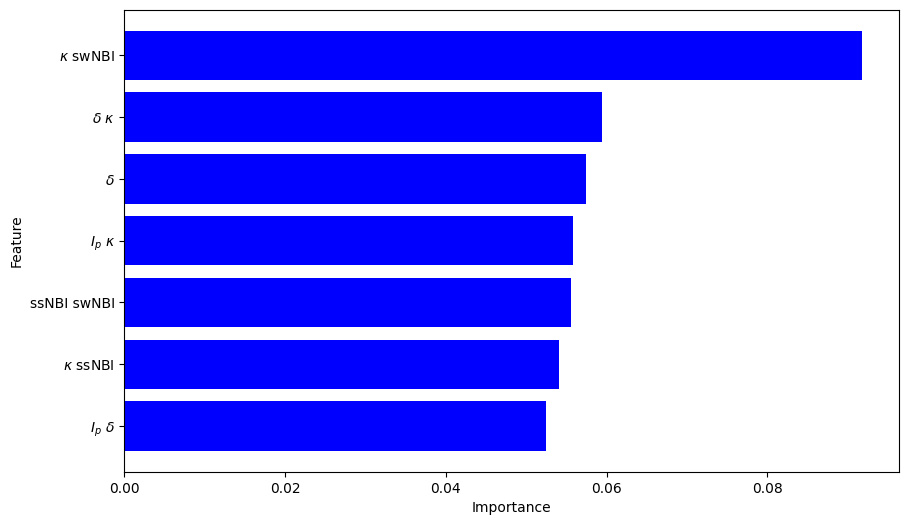

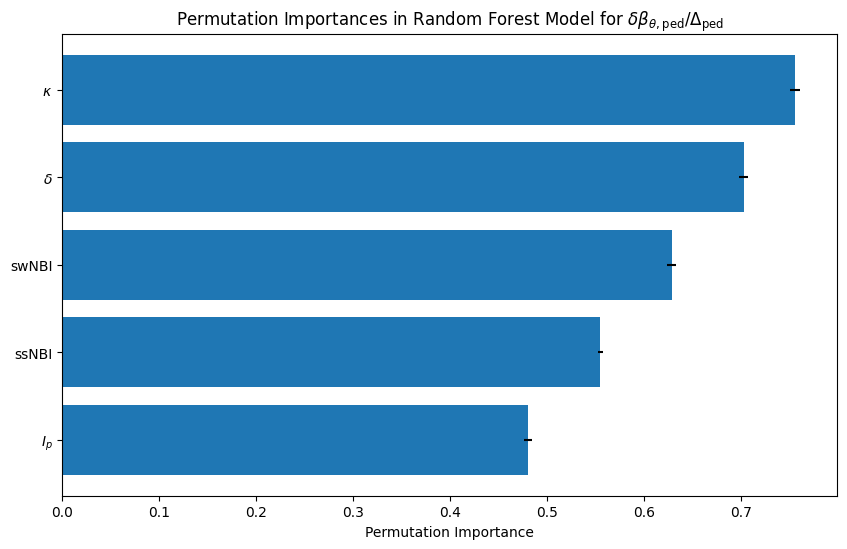

In [97]:

##### let's subsample for a quick model training
# X_sub = X[::100]
# y_sub = y[::100]
# X_sub = X[::10]
# y_sub = y[::10]
X_sub = X[:]
y_sub = y[:]
model.fit(X_sub, y_sub) ## training in ~5 seconds


# geo_quants = ['$\\delta$', '$\\kappa$']

# geo_quants = ['$I_p$','$A$','$\\delta$', '$\\kappa$']
# geo_quants = ['$I_p$','$\\delta$', '$\\kappa$']
geo_quants = [r'$I_p$', r'$\delta$', r'$\kappa$',    r'ssNBI', r'swNBI']

# Get the RandomForestRegressor from the pipeline
rf_model = model.named_steps['randomforestregressor']

# Feature importances
feature_importances = rf_model.feature_importances_

# Feature names
poly_feature_names = model.named_steps['polynomialfeatures'].get_feature_names_out()
feature_importance_dict = dict(zip(poly_feature_names, feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print sorted features with importances
print("Feature importances (sorted):")
for name, importance in sorted_features:
        print(f"Feature: {name}, Importance: {importance}")

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
feature_names_sorted = [item[0] for item in sorted_features]
importances_sorted = [item[1] for item in sorted_features]

# Mapping feature names to geo_quants
variable_mapping = {f'x{i}': name for i, name in enumerate(geo_quants)}
# Function to replace variables in composite names
def replace_feature_names(feature_name, mapping):
        pattern = re.compile(r'x\d+')
        return pattern.sub(lambda x: mapping[x.group()], feature_name)
# Replacing feature names with the actual variable names
feature_names_latex = [replace_feature_names(name, variable_mapping) for name in feature_names_sorted]

# Plot feature importances --- pick only top 7 variables!
top_filter = 7
plt.figure(figsize=(10, 6))
plt.barh(feature_names_latex[:top_filter], importances_sorted[:top_filter], color='b', align='center')
# ~ plt.barh(feature_names_sorted[:top_filter], importances_sorted[:top_filter], color='b', align='center')
# ~ plt.barh(feature_names_sorted[-top_filter:], importances_sorted[-top_filter:], color='b', align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
# plt.title('Feature Importances in Random Forest Model For ')
plt.gca().invert_yaxis()
# plt.show()
plt.savefig("feature_importance_deltabetaped_overDeltaped_MASTU.pdf",bbox_inches='tight', pad_inches=0.1)


#### PERMUTATION IMPORTANCE

degree = 2

# # Create a pipeline with standardization, polynomial features, and Random Forest
# model = make_pipeline(StandardScaler(), PolynomialFeatures(degree), RandomForestRegressor())

# # Fit the model
# model.fit(X, y)

# Calculate R^2
# r2 = model.score(X, y)
# print("R^2:", r2)

# Compute permutation importance
result = permutation_importance(model, X_sub, y_sub, n_repeats=10, random_state=42, scoring='r2')

# Get feature names
poly_feature_names = model.named_steps['polynomialfeatures'].get_feature_names_out()

# Exclude the constant term '1'
important_features = [name for name in poly_feature_names if name != '1']

# Get the permutation importance results
importances_mean = result.importances_mean
importances_std = result.importances_std

# Create a sorted list of features based on importance
sorted_idx = importances_mean.argsort()

# Plot the permutation importance
plt.figure(figsize=(10, 6))
sorted_important_features = np.array(geo_quants)[sorted_idx]
sorted_importances_mean = importances_mean[sorted_idx]
bars=plt.barh(range(len(sorted_importances_mean)), sorted_importances_mean, xerr=importances_std[sorted_idx])
plt.yticks(range(len(importances_mean[sorted_idx])), sorted_important_features)

plt.xlabel("Permutation Importance")
plt.title("Permutation Importances in Random Forest Model for $\\delta \\beta_{{\\theta,\\mathrm{{ped}}}}/\\Delta_{{\\mathrm{{ped}}}}$")
# plt.show()
plt.savefig("permutation_importance_deltabetaped_overDeltaped_MASTU.pdf",bbox_inches='tight', pad_inches=0.1)





######---- end jfp edits

# # Remove highly correlated features
# X=X.astype("float64")
# X=np.nan_to_num(X, nan=0)
# X[np.where(np.isnan(X))]=0
# X_cleaned, removed_features = remove_highly_correlated_features(X, threshold=0.8)
# print("Removed features indices:", removed_features)

# X = X_cleaned

# #pedestal height is parameter to predict
# y = a.Beta_ped

# # attempts to fix NaN error
# print(X[np.where(np.isinf(X))])
# for i in range(len(X)):
#     X[i][np.where(np.isnan(X[i]))]=0
# y[np.where(np.isnan(y))]=0

# print("yep",X[np.where(np.isnan(X))])
# X.T[0] =X.T[0]/1e18
# print(X)
# print(np.where(np.isnan(y)==True))
# # for i in range(len(X.T)):
# #     z = np.isfinite(X.T[i])
# #     print(np.where(z==False))
# print(X.shape, y.shape)
# print(y)
# print(X.dtype)
# print(y.dtype)


# #fit model
# model.fit(X, y)
# # Calculate R^2
# r2 = model.score(X, y)
# print("R^2 random forest:", r2) #



In [98]:
print(importances_mean)

[0.48052963 0.70317992 0.75614046 0.5551249  0.62872065]


In [99]:
print(importances_std)

[0.00392658 0.00454598 0.00547614 0.0025361  0.00436242]


In [94]:
print(importances_mean)

[0.80773371 0.73847887 0.68693364 0.46446987 0.39861311]


In [95]:
print(importances_std)

[0.00630856 0.00400857 0.00555476 0.00389981 0.00269921]


In [ ]:
species = ('$I_p$', '$\delta$', '$\kappa$','sNBI', 'swNBI')

# 'Gradient': [(0.68322676, 0.43957089, 0.58501302, 0.69026528, 0.48931493, 0.4579069),(0.00670258, 0.00237819, 0.0041797,  0.00834437, 0.00409269, 0.00290676)],
penguin_means = {
                 'Height': [[0.80773371, 0.73847887, 0.68693364, 0.46446987 ,0.39861311],[0.00630856 ,0.00400857, 0.00555476, 0.00389981, 0.00269921]],
                 'Width': [[0.48052963, 0.70317992, 0.75614046 ,0.5551249,  0.62872065], [0.00392658 ,0.00454598, 0.00547614, 0.0025361,  0.00436242]]}
x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0
colors = ["gold",  "darkorange"]

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=attribute, yerr=measurement[1], alpha = 0.7, color=colors[multiplier])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Permutation Importances', fontsize = 15)
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(loc='upper right', ncols=3, fontsize = 12)
ax.set_ylim(0, .8)
plt.savefig("plots/barPlot2.jpeg", dpi=600)

plt.show()



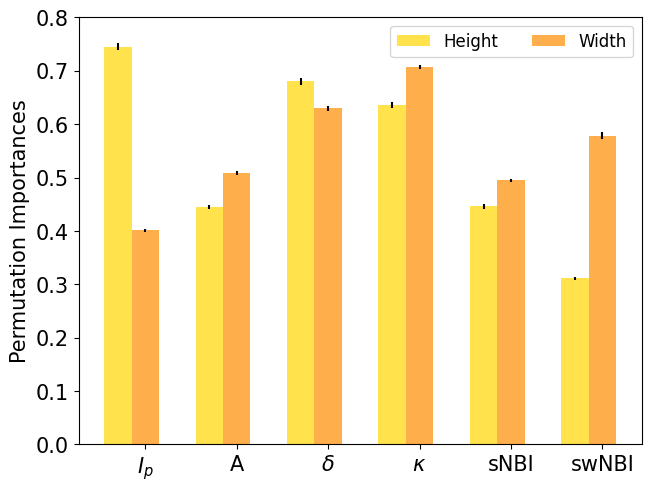

In [91]:
species = ('$I_p$','A', '$\delta$', '$\kappa$','sNBI', 'swNBI')

# 'Gradient': [(0.68322676, 0.43957089, 0.58501302, 0.69026528, 0.48931493, 0.4579069),(0.00670258, 0.00237819, 0.0041797,  0.00834437, 0.00409269, 0.00290676)],
penguin_means = {
                 'Height': [(0.74479267, 0.44558918, 0.68001397, 0.63599853, 0.44597833, 0.31133402),(0.00690351, 0.00363156, 0.00686507 ,0.00507459, 0.00415309, 0.00249668)],
                 'Width': [(0.40085782, 0.50904738, 0.63001739 ,0.70709698, 0.49471539 ,0.57838864), [0.00317735, 0.0038481 , 0.00456676, 0.00441188, 0.00272058 ,0.00621651]]}
x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0
colors = ["gold",  "darkorange"]

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=attribute, yerr=measurement[1], alpha = 0.7, color=colors[multiplier])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Permutation Importances', fontsize = 15)
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(loc='upper right', ncols=3, fontsize = 12)
ax.set_ylim(0, .8)
plt.savefig("plots/barPlot2.jpeg", dpi=600)

plt.show()



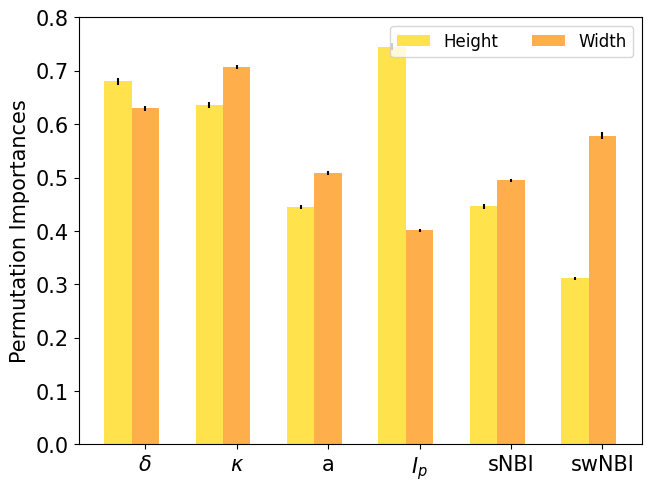

In [90]:
species = ('$\delta$', '$\kappa$','a', '$I_p$','sNBI', 'swNBI')

# 'Gradient': [(0.68322676, 0.43957089, 0.58501302, 0.69026528, 0.48931493, 0.4579069),(0.00670258, 0.00237819, 0.0041797,  0.00834437, 0.00409269, 0.00290676)],
penguin_means = {
                 'Height': [( 0.68001397, 0.63599853,0.44558918,0.74479267,  0.44597833, 0.31133402),( 0.00686507 ,0.00507459,0.00363156,0.00690351,  0.00415309, 0.00249668)],
                 'Width': [(0.63001739 ,0.70709698,0.50904738, 0.40085782,  0.49471539 ,0.57838864), [  0.00456676, 0.00441188,0.0038481 ,0.00317735, 0.00272058 ,0.00621651]]}
x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0
colors = ["gold",  "darkorange"]

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=attribute, yerr=measurement[1], alpha = 0.7, color=colors[multiplier])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Permutation Importances', fontsize = 15)
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(loc='upper right', ncols=3, fontsize = 12)
ax.set_ylim(0, .8)
plt.savefig("plots/barPlot2.jpeg", dpi=600)

plt.show()



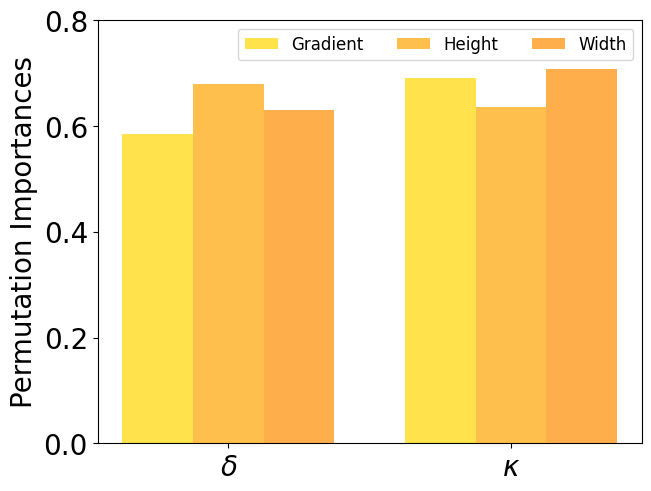

In [89]:
species = ('$\delta$', '$\kappa$')


penguin_means = {'Gradient': (0.58501302, 0.69026528),
                 'Height': (0.68001397, 0.63599853),
                 'Width': (0.63001739 ,0.70709698)}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
colors = ["gold", "orange", "darkorange"]
for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color = colors[multiplier], alpha=0.7)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Permutation Importances', fontsize = 20)
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.legend(loc='upper right', ncols=3, fontsize = 12)
ax.set_ylim(0, .8)
plt.savefig("plots/barPlot.jpeg", dpi=600)

plt.show()
